In [3]:
# ---------------------------------------------
# 1. Import necessary libraries
# ---------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append('/Users/sarahurbut/dtwin_noulli/scripts')
      # <-- REMOVE: Jupyter magic, not valid in .py scripts
from dt import *
import torch
import pandas as pd
# Set seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)

%load_ext autoreload

%autoreload 2


2025-07-18 05:58:49.798 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-07-18 05:58:49.801 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-18 05:58:49.802 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-18 05:58:49.802 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-18 05:58:49.802 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-18 05:58:49.846 
  command:

    streamlit run /opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-pac

## Match all signatures

In [5]:

# ---------------------------------------------
# 2. Load data: PRS, patient IDs, PRS/disease names, G-matrix, covariates
# ---------------------------------------------
# Load polygenic risk scores (thetas) and processed patient IDs
# These are the main subject IDs and their PRS values
# thetas: (n_individuals, n_prs)
thetas = np.load("/Users/sarahurbut/aladynoulli2/pyScripts/thetas.npy")
processed_ids = np.load("/Users/sarahurbut/aladynoulli2/pyScripts/processed_patient_ids.npy").astype(int)

# thetas: shape (N, n_signatures, n_timepoints)
mean_thetas = thetas.mean(axis=0)  # shape: (n_signatures, n_timepoints)
std_thetas = thetas.std(axis=0)    # shape: (n_signatures, n_timepoints)

# Broadcasting: (N, n_signatures, n_timepoints) - (n_signatures, n_timepoints)
z_thetas = (thetas - mean_thetas[None, :, :]) / std_thetas[None, :, :]
# If you want just deviation (not z-score), use:
# dev_thetas = thetas - mean_thetas[None, :, :]

In [6]:

# Load PRS names and labels for plotting/interpretation
prs_names = pd.read_csv('/Users/sarahurbut/aladynoulli2/pyScripts/prs_names.csv')
prs_labels = prs_names['Names'].tolist()

# Load disease names for reference
# (Assumes second column contains names)
disease_names_df = pd.read_csv("/Users/sarahurbut/aladynoulli2/pyScripts/disease_names.csv")
disease_names = disease_names_df.iloc[:, 1].tolist()

# Load G-matrix (genotype/PRS matrix)
G = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/G_matrix.pt")
G = G.detach().cpu().numpy()

# Load covariate data (demographics, labs, etc.)
cov = pd.read_csv('/Users/sarahurbut/aladynoulli2/pyScripts/matched_pce_df_400k.csv')
cov.columns = cov.columns.str.strip()
cov = cov.rename(columns={cov.columns[0]: 'eid'})
cov['eid'] = cov['eid'].astype(int)
# Parse enrollment date and calculate age at enrollment
cov['enrollment'] = pd.to_datetime(cov['Enrollment_Date'], errors='coerce')
cov['age_at_enroll'] = cov['enrollment'].dt.year - cov['birth_year']
age_at_enroll = dict(zip(cov['eid'], cov['age_at_enroll']))
eid_to_yob = dict(zip(cov['eid'], cov['birth_year']))

# ---------------------------------------------
# 3. Load and process prescription data
# ---------------------------------------------
prescription_path = '/Users/sarahurbut/aladynoulli2/pyScripts/prescriptions.csv'
df_treat = pd.read_csv(prescription_path)
df_treat['eid'] = df_treat['eid'].astype(int)
df_treat = df_treat.merge(cov[['eid', 'birth_year']], on='eid', how='left')
df_treat['from'] = pd.to_datetime(df_treat['from'], errors='coerce')

# ---------------------------------------------
# 4. Check overlap between covariate and processed IDs
# ---------------------------------------------
# Convert processed_ids to pandas Series for convenience
processed_ids = pd.Series(processed_ids)

cov_eids = set(cov['eid'])
processed_eids = set(processed_ids)

print("EIDs in cov but not in processed_ids:", cov_eids - processed_eids)
print("EIDs in processed_ids but not in cov:", processed_eids - cov_eids)
print("Number of EIDs in cov:", len(cov_eids))
print("Number of EIDs in processed_ids:", len(processed_eids))
print("Number of overlapping EIDs:", len(cov_eids & processed_eids)) ## should be 400K


# ---------------------------------------------
# 5. Filter prescription data for drug category (e.g., statins)
# ---------------------------------------------
drug_category = "statins"  # or "antidiabetic", etc.
df_drug = df_treat if drug_category == "All" else df_treat[df_treat['category'] == drug_category]
num_unique_eids = df_drug['eid'].nunique()
print(f"Number of unique individuals in {drug_category}: {num_unique_eids}")
# EIDs in df_treat and cov
treat_eids = set(df_drug['eid'])
overlap_treat_cov = treat_eids & cov_eids
print("Number of people in df_drug:", len(treat_eids))
print("Number of people in both df_drug and cov:", len(overlap_treat_cov))

# ---------------------------------------------
# 6. Identify incident treated individuals (first prescription after enrollment)
# ---------------------------------------------
# Find first prescription for each person
first_presc = df_drug.groupby('eid')['from'].min().reset_index()
first_presc = first_presc.merge(
    cov[['eid', 'Birthdate','Enrollment_Date']],
    left_on='eid', right_on='eid', how='left'
)
first_presc['Birthdate'] = pd.to_datetime(first_presc['Birthdate'])
first_presc['from'] = pd.to_datetime(first_presc['from'])
# Calculate age at first prescription
first_presc['age_at_first_script'] = (first_presc['from'] - first_presc['Birthdate']).dt.days / 365.25
# Only keep those whose first prescription is after enrollment (incident users)
incident_treated = first_presc[first_presc['from'] > first_presc['Enrollment_Date']].copy()
incident_treated['age_at_first_script'] = (incident_treated['from'] - incident_treated['Birthdate']).dt.days/365.25
incident_treated['years_since_30'] = (incident_treated['age_at_first_script'] - 30).round()
incident_treated.shape

# ---------------------------------------------
# 7. Add prior disease/condition flags to covariate table
# ---------------------------------------------
# These functions flag prior disease status at enrollment for each subject
prev_condition(cov, 'Dm_Any', 'Dm_censor_age', 'age_enrolled', 'prev_dm')
prev_condition(cov, 'DmT1_Any', 'DmT1_censor_age', 'age_enrolled', 'prev_dm1')
prev_condition(cov, 'Ht_Any', 'Ht_censor_age', 'age_enrolled', 'prev_ht')
prev_condition(cov, 'HyperLip_Any', 'HyperLip_censor_age', 'age_enrolled', 'prev_hl')

# ---------------------------------------------
# 8. Build mapping dictionaries for covariates and PRS
# ---------------------------------------------
ldl_idx = prs_labels.index('LDL_SF')   # LDL PRS index
cad_idx = prs_labels.index('CAD')      # CAD PRS index
eid_to_dm2_prev = dict(zip(cov['eid'], cov['prev_dm']))
eid_to_antihtnbase = dict(zip(cov['eid'], cov['prev_ht']))
eid_to_htn = dict(zip(cov['eid'], cov['prev_ht']))
eid_to_smoke = dict(zip(cov['eid'], cov['SmokingStatusv2']))
eid_to_dm1_prev = dict(zip(cov['eid'], cov['prev_dm1']))
eid_to_hl_prev = dict(zip(cov['eid'], cov['prev_hl']))
eid_to_sex = dict(zip(cov['eid'],cov['Sex']))
eid_to_age = dict(zip(cov['eid'],cov['age_enrolled']))
eid_to_ldl_prs = {eid: G[i, ldl_idx] for i, eid in enumerate(processed_ids)}
eid_to_cad_prs = {eid: G[i, cad_idx] for i, eid in enumerate(processed_ids)}
eid_to_race = dict(zip(cov['eid'],cov['race']))
eid_to_pce_goff = dict(zip(cov['eid'],cov['pce_goff']))
eid_to_tchol = dict(zip(cov['eid'],cov['tchol']))
eid_to_hdl = dict(zip(cov['eid'],cov['hdl']))
eid_to_sbp = dict(zip(cov['eid'],cov['SBP']))

# ---------------------------------------------
# 9. Define treated and control groups (EIDs and time zero)
# ---------------------------------------------
# Treated: incident users (first prescription after enrollment)
treated_eids = incident_treated['eid']
treated_t0s = incident_treated['years_since_30']
treated_t0_dict = dict(zip(treated_eids, treated_t0s))
len(treated_t0_dict)
len(treated_eids)

# Controls: those not in treated group
# (untreated_eids: EIDs for controls)
treated_eids_set = set(incident_treated['eid'])
untreated_eids = [eid for eid in processed_ids if eid not in treated_eids_set]

# When selecting from covariate DataFrame:
controls_df = cov[cov['eid'].isin(untreated_eids)]
controls = cov[cov['eid'].isin(untreated_eids)].copy()
controls['years_since_30'] = (controls['age_enrolled'] - 30).round()
control_eids = controls['eid']
control_t0s = controls['years_since_30']
print(len(untreated_eids))
print(len(treated_eids_set))
print(len(untreated_eids)+len(treated_eids_set))

# 365845
# 34155
# 400000


# ---------------------------------------------
# 10. Build covariate dictionary for feature engineering
# ---------------------------------------------
covariate_dicts = {
    'age_at_enroll': eid_to_age,
    'sex': eid_to_sex,
    'dm2_prev': eid_to_dm2_prev,
    'antihtnbase': eid_to_antihtnbase,
    'dm1_prev': eid_to_hl_prev,  # Note: check if this is intentional
    'smoke': eid_to_smoke,
    'ldl_prs': eid_to_ldl_prs,
    'cad_prs': eid_to_cad_prs,
    'tchol': eid_to_tchol,
    'hdl': eid_to_hdl,
    'sbp': eid_to_sbp,
    'pce_goff': eid_to_pce_goff
}

# ---------------------------------------------
# 11. Prepare lists of EIDs and t0s for treated and controls
# ---------------------------------------------
from dt import *

treated_eids_list = list(treated_eids)
treated_t0s_list = list(treated_t0s)
control_eids_list = list(control_eids)
control_t0s_list = list(control_t0s)

# ---------------------------------------------
# 12. Build features for matching (using build_features)
# ---------------------------------------------

sig_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

treated_features, treated_indices, treated_eids_matched = build_features(
    treated_eids_list, treated_t0s_list, processed_ids, z_thetas, covariate_dicts,
    sig_indices=sig_indices
)
control_features, control_indices, control_eids_matched = build_features(
    control_eids_list, control_t0s_list, processed_ids, z_thetas, covariate_dicts,
    sig_indices=sig_indices
)

#treated_features, treated_indices, treated_eids_matched = build_features(
 #   treated_eids_list, treated_t0s_list, processed_ids, thetas, covariate_dicts,
  #  sig_indices=sig_indices
#)
#control_features, control_indices, control_eids_matched = build_features(
    #control_eids_list, control_t0s_list, processed_ids, thetas, covariate_dicts,
    #sig_indices=sig_indices
#)


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_73777/2977109398.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G = torch.load("/Users/sarahurbut/Library/Cl

EIDs in cov but not in processed_ids: set()
EIDs in processed_ids but not in cov: set()
Number of EIDs in cov: 400000
Number of EIDs in processed_ids: 400000
Number of overlapping EIDs: 400000
Number of unique individuals in statins: 78028
Number of people in df_drug: 78028
Number of people in both df_drug and cov: 68370
365845
34155
400000


0
0


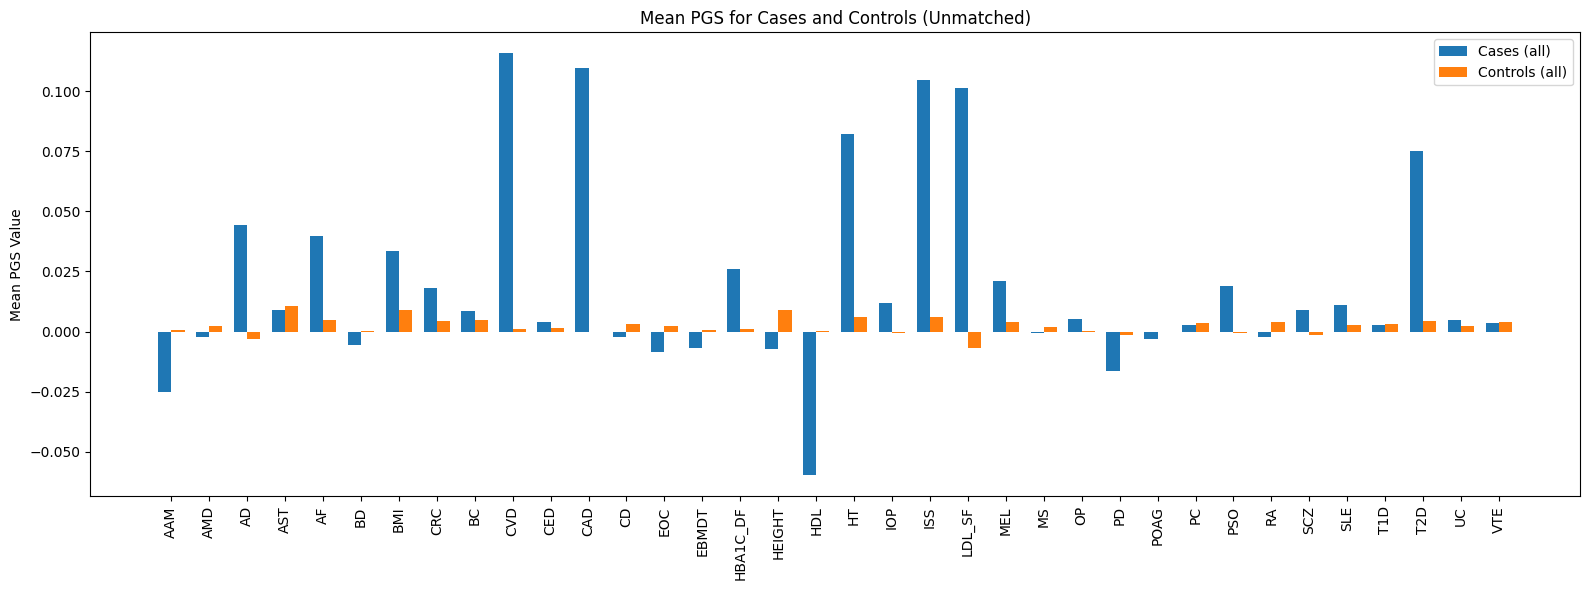

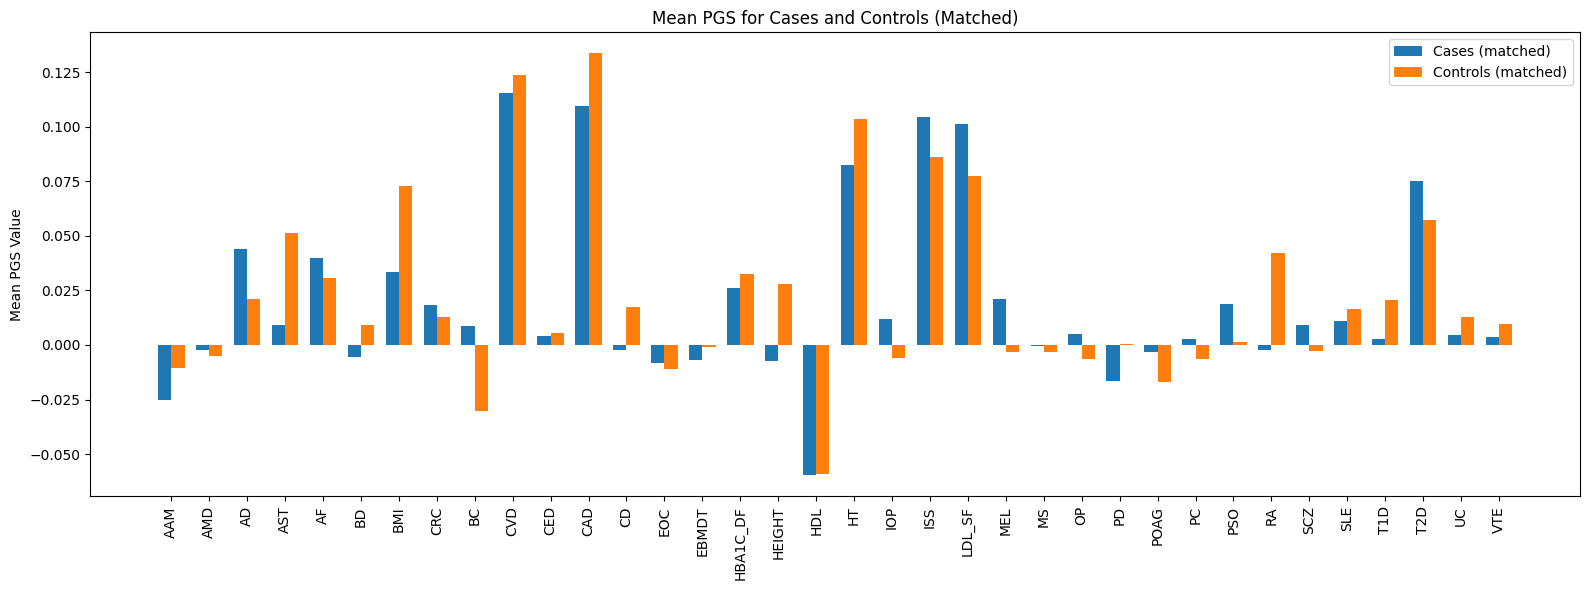

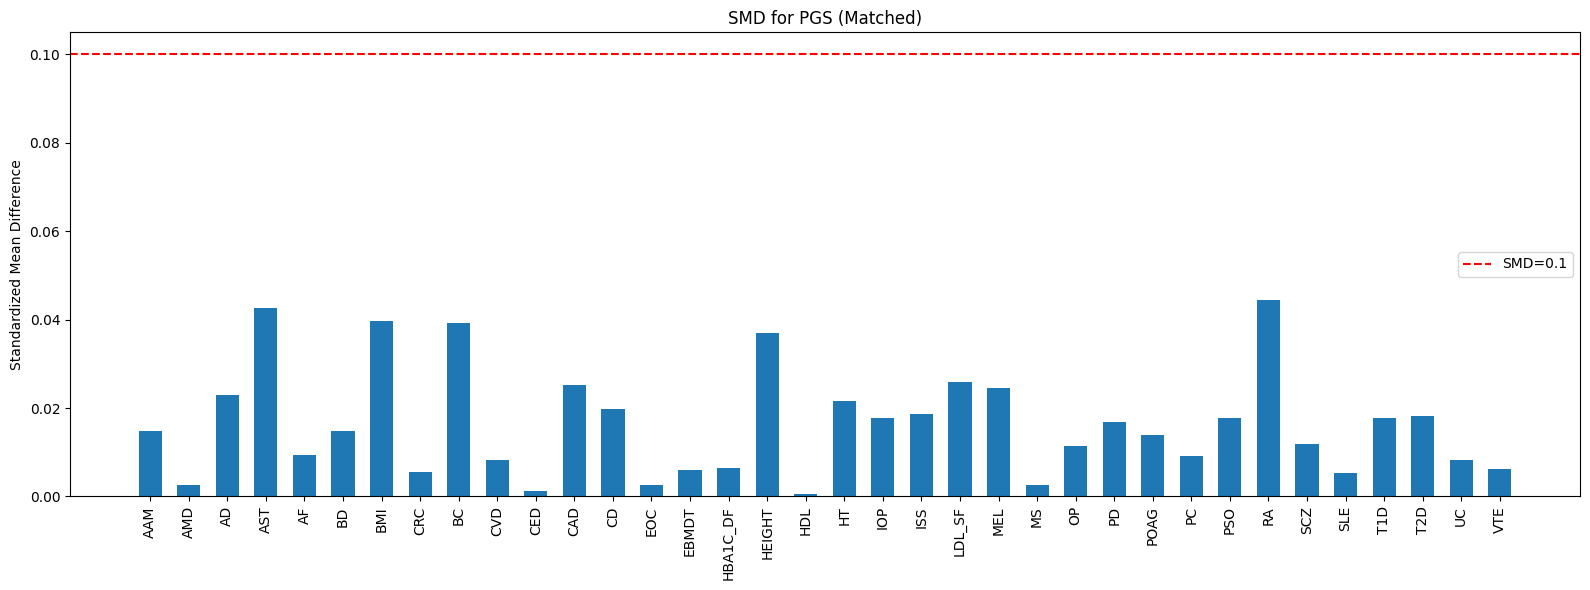

(34155, 29)
(365845, 29)
(34155, 29)
(29346, 29)
Number of missing matched control EIDs: 0
[]
Number of unique matched_control_eids: 29346
Total matched_control_eids: 34155

Sex distribution table:


,Treated (all),Control (all),Treated (matched),Control (matched)
0,0.453,0.552,0.453,0.499
1,0.547,0.448,0.547,0.501



SmokingStatusv2 distribution table:


,Treated (all),Control (all),Treated (matched),Control (matched)
Current,0.142,0.106,0.142,0.102
Never,0.473,0.537,0.473,0.513
Previous,0.386,0.357,0.386,0.385



prev_dm distribution table:


,Treated (all),Control (all),Treated (matched),Control (matched)
0,0.939,0.94,0.939,0.952
1,0.061,0.06,0.061,0.048



prev_hl distribution table:


,Treated (all),Control (all),Treated (matched),Control (matched)
0,0.859,0.835,0.859,0.859
1,0.141,0.165,0.141,0.141



race distribution table:


,Treated (all),Control (all),Treated (matched),Control (matched)
asian,0.025,0.022,0.025,0.015
black,0.009,0.016,0.009,0.008
mixed,0.004,0.006,0.004,0.004
other,0.006,0.009,0.006,0.005
white,0.956,0.948,0.956,0.967



prev_ht distribution table:


,Treated (all),Control (all),Treated (matched),Control (matched)
0,0.61,0.706,0.61,0.675
1,0.39,0.294,0.39,0.325


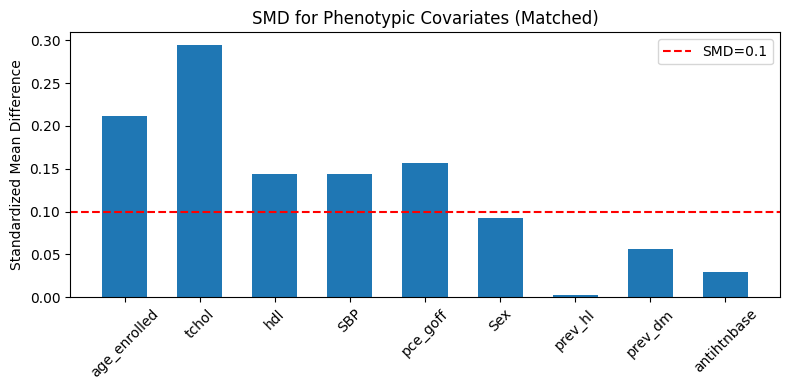

age_enrolled: SMD = 0.211
tchol: SMD = 0.295
hdl: SMD = 0.144
SBP: SMD = 0.144
pce_goff: SMD = 0.157
Sex: SMD = 0.092
prev_hl: SMD = 0.002
prev_dm: SMD = 0.056
antihtnbase: SMD = 0.029


In [8]:


# ---------------------------------------------
# 13. Impute missing values and standardize features
# ---------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np
# Impute missing values (mean imputation)
imputer = SimpleImputer(strategy='mean')
all_features = np.vstack([treated_features, control_features])
imputer.fit(all_features)
treated_features_imputed = imputer.transform(treated_features)
control_features_imputed = imputer.transform(control_features)
# Standardize features (zero mean, unit variance)
scaler = StandardScaler().fit(np.vstack([treated_features_imputed, control_features_imputed]))
treated_features_std = scaler.transform(treated_features_imputed)
control_features_std = scaler.transform(control_features_imputed)
print(np.isnan(control_features_std).sum())
print(np.isnan(treated_features_std).sum())

# ---------------------------------------------
# 14. Perform nearest neighbor matching (1:1 matching)
# ---------------------------------------------
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(control_features_std)
distances, indices = nn.kneighbors(treated_features_std)
matched_control_indices = [control_indices[i[0]] for i in indices]
matched_treated_indices = treated_indices  # these are the treateds you matched
matched_control_eids = [control_eids_matched[i] for i in indices.flatten()]

# ---------------------------------------------
# 15. Calculate mean PRS for matched/unmatched cases and controls
# ---------------------------------------------
treated_indices = [np.where(processed_ids == int(eid))[0][0] for eid in treated_eids]
untreated_indices = [np.where(processed_ids == int(eid))[0][0] for eid in untreated_eids]

means_matched_cases = G[matched_treated_indices].mean(axis=0)
means_matched_controls = G[matched_control_indices].mean(axis=0)
means_unmatched_cases = G[treated_indices].mean(axis=0)
means_unmatched_controls = G[untreated_indices].mean(axis=0)

# ---------------------------------------------
# 16. Plot mean PRS for cases/controls (matched and unmatched)
# ---------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(len(prs_labels))
width = 0.35
fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(x - width/2, means_unmatched_cases, width, label='Cases (all)')
ax.bar(x + width/2, means_unmatched_controls, width, label='Controls (all)')
ax.set_ylabel('Mean PGS Value')
ax.set_title('Mean PGS for Cases and Controls (Unmatched)')
ax.set_xticks(x)
ax.set_xticklabels(prs_labels, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(x - width/2, means_matched_cases, width, label='Cases (matched)')
ax.bar(x + width/2, means_matched_controls, width, label='Controls (matched)')
ax.set_ylabel('Mean PGS Value')
ax.set_title('Mean PGS for Cases and Controls (Matched)')
ax.set_xticks(x)
ax.set_xticklabels(prs_labels, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

# ---------------------------------------------
# 17. Compute and plot standardized mean differences (SMD) for PRS
# ---------------------------------------------
def compute_smd(x1, x0):
    m1, m0 = np.nanmean(x1), np.nanmean(x0)
    s1, s0 = np.nanstd(x1), np.nanstd(x0)
    return np.abs(m1 - m0) / np.sqrt((s1**2 + s0**2) / 2)

smds_matched = []
for i, prs in enumerate(prs_labels):
    smds_matched.append(compute_smd(
        G[matched_treated_indices, i], G[matched_control_indices, i]
    ))

x = np.arange(len(prs_labels))
plt.figure(figsize=(16,6))
plt.bar(x, smds_matched, width=0.6)
plt.axhline(0.1, color='red', linestyle='--', label='SMD=0.1')
plt.xticks(x, prs_labels, rotation=90)
plt.ylabel('Standardized Mean Difference')
plt.title('SMD for PGS (Matched)')
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------------------------
# 18. Build group DataFrames for summary tables
# ---------------------------------------------
treated_eids = list(treated_eids)
groups = {
    'Treated (all)': cov[cov['eid'].isin(treated_eids_matched)],
    'Control (all)': cov[cov['eid'].isin(untreated_eids)],
    'Treated (matched)': cov[cov['eid'].isin(treated_eids_matched)],
    'Control (matched)': cov[cov['eid'].isin(matched_control_eids)],
}

print(groups['Treated (all)'].shape)
print(groups['Control (all)'].shape)
print(groups['Treated (matched)'].shape)
print(groups['Control (matched)'].shape)
len(matched_control_eids)



missing = set(matched_control_eids) - set(cov['eid'])
print(f"Number of missing matched control EIDs: {len(missing)}")
print(list(missing)[:10])  # Show a few examples
print(f"Number of unique matched_control_eids: {len(set(matched_control_eids))}")
print(f"Total matched_control_eids: {len(matched_control_eids)}")

# ---------------------------------------------
# 19. Summarize categorical covariates by group
# ---------------------------------------------
categorical_covariates = ['Sex', 'SmokingStatusv2', 'prev_dm', 'prev_hl','race','prev_ht']
for covariate in categorical_covariates:
    # Get all possible categories
    categories = set()
    for df in groups.values():
        categories.update(df[covariate].dropna().unique())
    categories = sorted(categories)
    cat_summary = pd.DataFrame(index=categories)
    for group_name, df in groups.items():
        cat_summary[group_name] = df[covariate].value_counts(normalize=True).reindex(categories, fill_value=0)
    print(f"\n{covariate} distribution table:")
    display(cat_summary.round(3))

# ---------------------------------------------
# 20. Summarize continuous covariates by group
# ---------------------------------------------
covariates = ['age_at_enroll', 'tchol', 'hdl', 'SBP']
summary = pd.DataFrame(index=covariates)
groups = {
    'Treated (all)': cov[cov['eid'].isin(treated_eids_matched)],
    'Control (all)': cov[cov['eid'].isin(untreated_eids)],
    'Treated (matched)': cov[cov['eid'].isin(treated_eids_matched)],
    'Control (matched)': cov[cov['eid'].isin(matched_control_eids)],
}
for group_name, df in groups.items():
    summary[(group_name, 'mean')] = df[covariates].mean()
    summary[(group_name, 'std')] = df[covariates].std()
# Reorder columns for clarity
summary = summary.reindex(columns=pd.MultiIndex.from_product(
    [['Treated (all)', 'Control (all)', 'Treated (matched)', 'Control (matched)'], ['mean', 'std']]
))
# Display as a nice table
summary.round(2)

# ---------------------------------------------
# 21. Compute and plot SMD for phenotypic covariates (matched)
# ---------------------------------------------
treated_matched = cov[cov['eid'].isin(treated_eids_matched)]
control_matched = cov[cov['eid'].isin(matched_control_eids)]
def compute_smd(x1, x0):
    m1, m0 = np.nanmean(x1), np.nanmean(x0)
    s1, s0 = np.nanstd(x1), np.nanstd(x0)
    return np.abs(m1 - m0) / np.sqrt((s1**2 + s0**2) / 2)

covariates = ['age_enrolled', 'tchol', 'hdl', 'SBP', 'pce_goff','Sex','prev_hl','prev_dm','antihtnbase']
smds_matched = []
for covariate in covariates:
    smds_matched.append(compute_smd(
        treated_matched[covariate], control_matched[covariate]
    ))

x = np.arange(len(covariates))
plt.figure(figsize=(8,4))
plt.bar(x, smds_matched, width=0.6)
plt.axhline(0.1, color='red', linestyle='--', label='SMD=0.1')
plt.xticks(x, covariates, rotation=45)
plt.ylabel('Standardized Mean Difference')
plt.title('SMD for Phenotypic Covariates (Matched)')
plt.legend()
plt.tight_layout()
plt.show()

# Print SMDs for reference
for covariate, smd in zip(covariates, smds_matched):
    print(f"{covariate}: SMD = {smd:.3f}")




window = 10  # or whatever window size you use
n_signatures = thetas.shape[1]

# Map from eid to t0
eid_to_t0 = {eid: t0 for eid, t0 in zip(treated_eids_list, treated_t0s_list)}
# Get t0 for each matched treated
matched_treated_t0s = [eid_to_t0[eid] for eid in treated_eids_matched]




In [6]:

treated_sig_windows = []
control_sig_windows = []

for t_idx, c_idx, t0 in zip(matched_treated_indices, matched_control_indices, matched_treated_t0s):
    t0 = int(t0)
    if t0 < window:
        continue  # skip if not enough history
    # Extract signature window for treated
    treated_sig = z_thetas[t_idx, :, t0-window:t0].flatten()
    # Extract signature window for control (using treated's t0)
    control_sig = z_thetas[c_idx, :, t0-window:t0].flatten()
    treated_sig_windows.append(treated_sig)
    control_sig_windows.append(control_sig)

treated_sig_windows = np.array(treated_sig_windows)
control_sig_windows = np.array(control_sig_windows)


print(treated_sig_windows.shape)

(34155, 210)


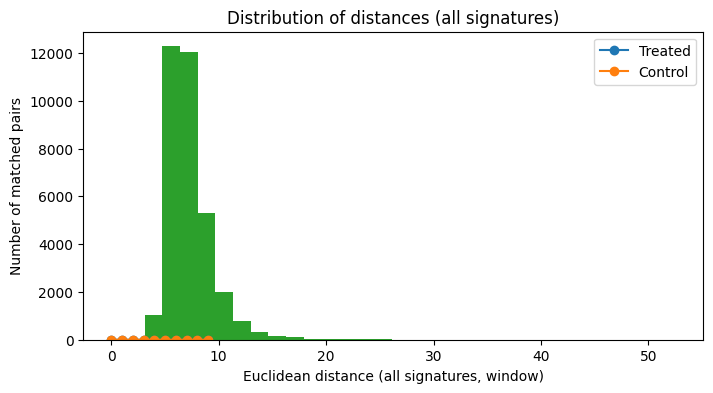

In [7]:

# Extract the time series for signature 5 and 3

# Indices for signature 5 and 3 in the flattened array
sig5_indices = np.arange(5 * window, 6 * window)
sig3_indices = np.arange(15 * window, 16 * window)

# Extract time series for each signature
treated_sig5 = treated_sig_windows[:, sig5_indices]
control_sig5 = control_sig_windows[:, sig5_indices]
treated_sig3 = treated_sig_windows[:, sig3_indices]
control_sig3 = control_sig_windows[:, sig3_indices]
plt.figure(figsize=(8,4))
plt.plot(np.arange(window), treated_sig5.mean(axis=0), label='Treated', marker='o')
plt.plot(np.arange(window), control_sig5.mean(axis=0), label='Control', marker='o')
plt.title('Signature 5 Profile (Mean) Prior to t0')
plt.xlabel('Time (steps before t0)')
plt.ylabel('Signature Value')
plt.legend()

all([matched_control_eids[n] == processed_ids[control_indices[indices[n][0]]] for n in range(len(matched_control_eids))])

from sklearn.metrics import pairwise_distances

# For each treated, get the distance to its matched control
# If you used NearestNeighbors, you may already have these distances
# Otherwise, compute them:
distances = []
for t_feat, c_idx in zip(treated_features_std, matched_control_indices):
    c_feat = control_features_std[control_indices.index(c_idx)]
    dist = np.linalg.norm(t_feat - c_feat)
    distances.append(dist)

import matplotlib.pyplot as plt
plt.hist(distances, bins=30)
plt.xlabel('Euclidean distance (all signatures, window)')
plt.ylabel('Number of matched pairs')
plt.title('Distribution of distances (all signatures)')
plt.show()

# do for just one sig

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_18609/3857369504.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G = torch.load("/Users/sarahurbut/Library/Cl

EIDs in cov but not in processed_ids: set()
EIDs in processed_ids but not in cov: set()
Number of EIDs in cov: 400000
Number of EIDs in processed_ids: 400000
Number of overlapping EIDs: 400000
Number of unique individuals in statins: 78028
Number of people in df_drug: 78028
Number of people in both df_drug and cov: 68370
365845
34155
400000
0
0


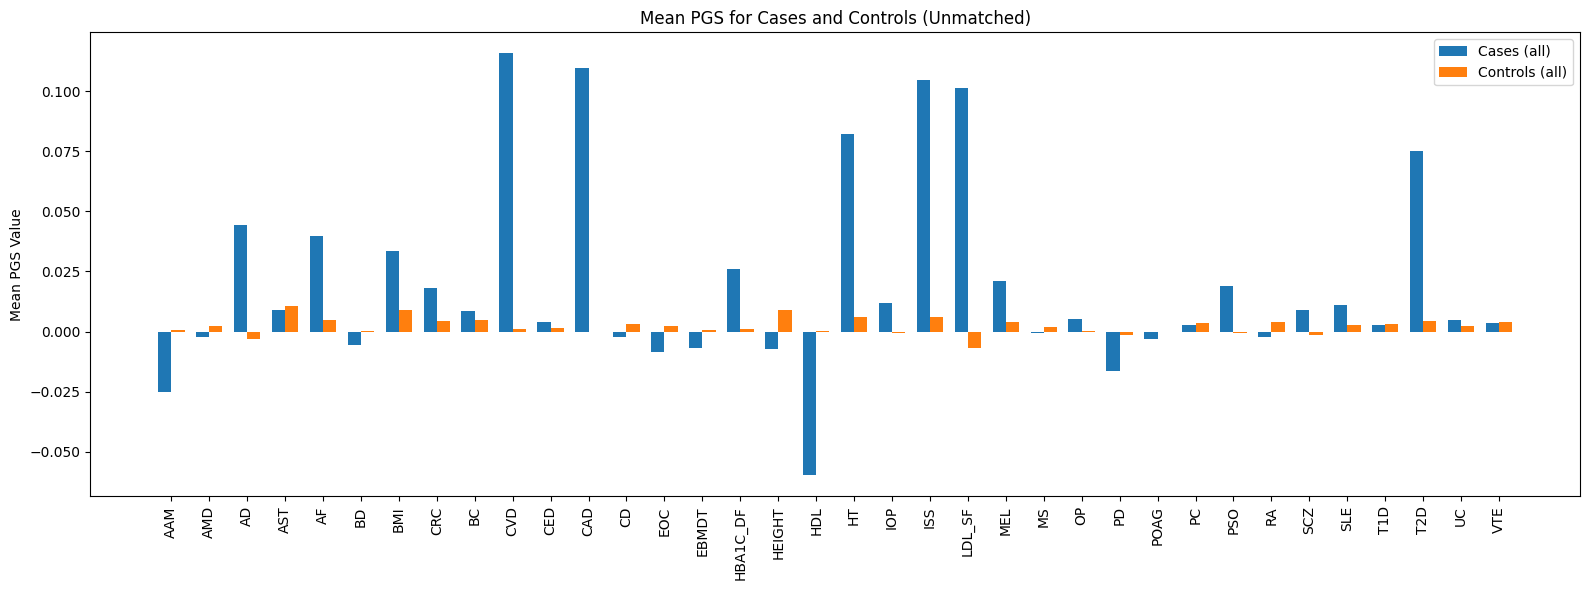

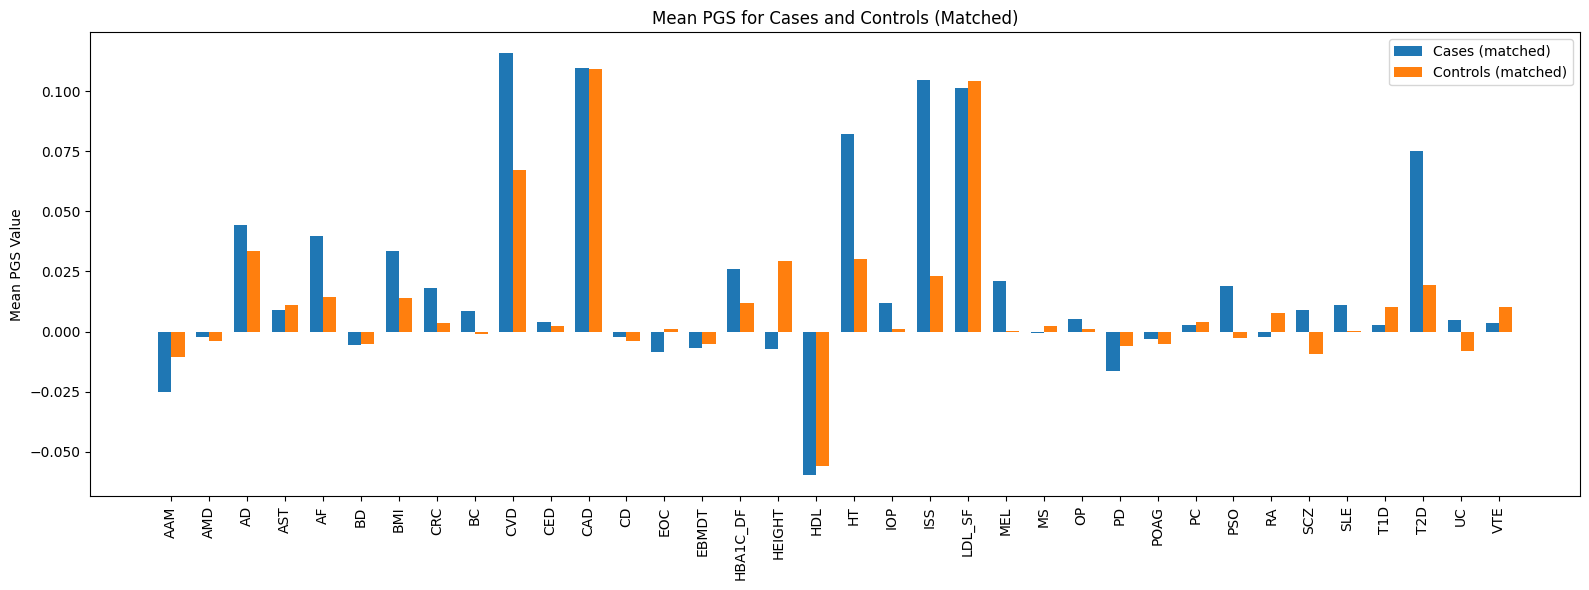

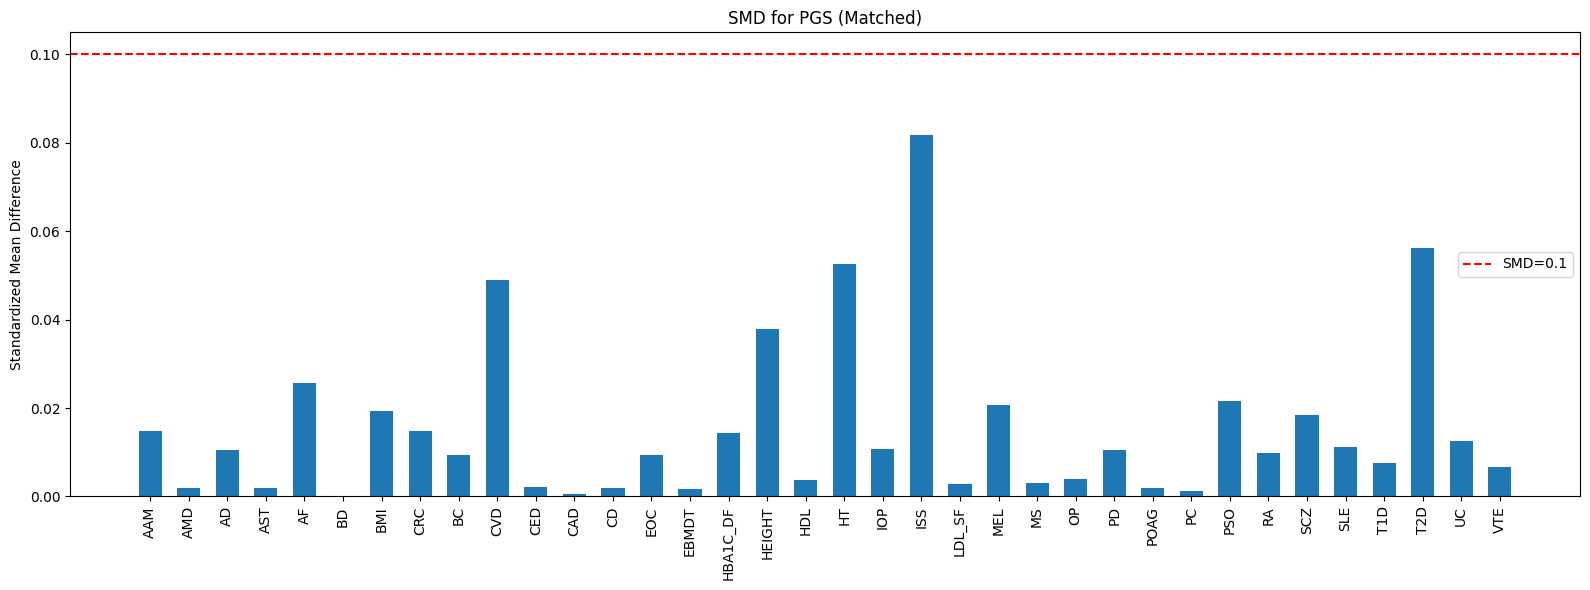

(34155, 29)
(365845, 29)
(34155, 29)
(30528, 29)
Number of missing matched control EIDs: 0
[]
Number of unique matched_control_eids: 30528
Total matched_control_eids: 34155

Sex distribution table:


,Treated (all),Control (all),Treated (matched),Control (matched)
0,0.453,0.552,0.453,0.462
1,0.547,0.448,0.547,0.538



SmokingStatusv2 distribution table:


,Treated (all),Control (all),Treated (matched),Control (matched)
Current,0.142,0.106,0.142,0.138
Never,0.473,0.537,0.473,0.475
Previous,0.386,0.357,0.386,0.386



prev_dm distribution table:


,Treated (all),Control (all),Treated (matched),Control (matched)
0,0.939,0.94,0.939,0.937
1,0.061,0.06,0.061,0.063



prev_hl distribution table:


,Treated (all),Control (all),Treated (matched),Control (matched)
0,0.859,0.835,0.859,0.85
1,0.141,0.165,0.141,0.15



race distribution table:


,Treated (all),Control (all),Treated (matched),Control (matched)
asian,0.025,0.022,0.025,0.019
black,0.009,0.016,0.009,0.010
mixed,0.004,0.006,0.004,0.005
other,0.006,0.009,0.006,0.007
white,0.956,0.948,0.956,0.959



prev_ht distribution table:


,Treated (all),Control (all),Treated (matched),Control (matched)
0,0.61,0.706,0.61,0.608
1,0.39,0.294,0.39,0.392


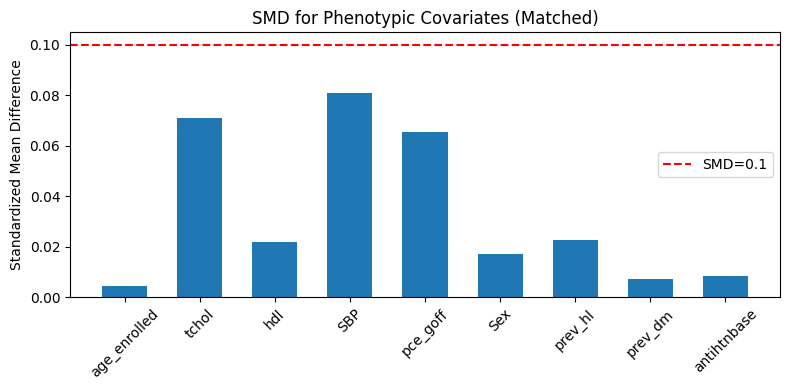

age_enrolled: SMD = 0.004
tchol: SMD = 0.071
hdl: SMD = 0.022
SBP: SMD = 0.081
pce_goff: SMD = 0.065
Sex: SMD = 0.017
prev_hl: SMD = 0.023
prev_dm: SMD = 0.007
antihtnbase: SMD = 0.008
We matched on signature  5 So we will check that signature
(34155, 10)


In [8]:
del matched_control_eids,matched_control_indices,matched_treated_t0s,matched_treated_indices
# ---------------------------------------------
# 2. Load data: PRS, patient IDs, PRS/disease names, G-matrix, covariates
# ---------------------------------------------
# Load polygenic risk scores (thetas) and processed patient IDs
# These are the main subject IDs and their PRS values
# thetas: (n_individuals, n_prs)
thetas = np.load("thetas.npy")
processed_ids = np.load("processed_patient_ids.npy").astype(int)

# Load PRS names and labels for plotting/interpretation
prs_names = pd.read_csv('prs_names.csv')
prs_labels = prs_names['Names'].tolist()

# Load disease names for reference
# (Assumes second column contains names)
disease_names_df = pd.read_csv("disease_names.csv")
disease_names = disease_names_df.iloc[:, 1].tolist()

# Load G-matrix (genotype/PRS matrix)
G = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/G_matrix.pt")
G = G.detach().cpu().numpy()

# Load covariate data (demographics, labs, etc.)
cov = pd.read_csv('/Users/sarahurbut/aladynoulli2/pyScripts/matched_pce_df_400k.csv')
cov.columns = cov.columns.str.strip()
cov = cov.rename(columns={cov.columns[0]: 'eid'})
cov['eid'] = cov['eid'].astype(int)
# Parse enrollment date and calculate age at enrollment
cov['enrollment'] = pd.to_datetime(cov['Enrollment_Date'], errors='coerce')
cov['age_at_enroll'] = cov['enrollment'].dt.year - cov['birth_year']
age_at_enroll = dict(zip(cov['eid'], cov['age_at_enroll']))
eid_to_yob = dict(zip(cov['eid'], cov['birth_year']))

# ---------------------------------------------
# 3. Load and process prescription data
# ---------------------------------------------
prescription_path = 'prescriptions.csv'
df_treat = pd.read_csv(prescription_path)
df_treat['eid'] = df_treat['eid'].astype(int)
df_treat = df_treat.merge(cov[['eid', 'birth_year']], on='eid', how='left')
df_treat['from'] = pd.to_datetime(df_treat['from'], errors='coerce')

# ---------------------------------------------
# 4. Check overlap between covariate and processed IDs
# ---------------------------------------------
# Convert processed_ids to pandas Series for convenience
processed_ids = pd.Series(processed_ids)

cov_eids = set(cov['eid'])
processed_eids = set(processed_ids)

print("EIDs in cov but not in processed_ids:", cov_eids - processed_eids)
print("EIDs in processed_ids but not in cov:", processed_eids - cov_eids)
print("Number of EIDs in cov:", len(cov_eids))
print("Number of EIDs in processed_ids:", len(processed_eids))
print("Number of overlapping EIDs:", len(cov_eids & processed_eids))

# ---------------------------------------------
# 5. Filter prescription data for drug category (e.g., statins)
# ---------------------------------------------
drug_category = "statins"  # or "antidiabetic", etc.
df_drug = df_treat if drug_category == "All" else df_treat[df_treat['category'] == drug_category]
num_unique_eids = df_drug['eid'].nunique()
print(f"Number of unique individuals in {drug_category}: {num_unique_eids}")
# EIDs in df_treat and cov
treat_eids = set(df_drug['eid'])
overlap_treat_cov = treat_eids & cov_eids
print("Number of people in df_drug:", len(treat_eids))
print("Number of people in both df_drug and cov:", len(overlap_treat_cov))

# ---------------------------------------------
# 6. Identify incident treated individuals (first prescription after enrollment)
# ---------------------------------------------
# Find first prescription for each person
first_presc = df_drug.groupby('eid')['from'].min().reset_index()
first_presc = first_presc.merge(
    cov[['eid', 'Birthdate','Enrollment_Date']],
    left_on='eid', right_on='eid', how='left'
)
first_presc['Birthdate'] = pd.to_datetime(first_presc['Birthdate'])
first_presc['from'] = pd.to_datetime(first_presc['from'])
# Calculate age at first prescription
first_presc['age_at_first_script'] = (first_presc['from'] - first_presc['Birthdate']).dt.days / 365.25
# Only keep those whose first prescription is after enrollment (incident users)
incident_treated = first_presc[first_presc['from'] > first_presc['Enrollment_Date']].copy()
incident_treated['age_at_first_script'] = (incident_treated['from'] - incident_treated['Birthdate']).dt.days/365.25
incident_treated['years_since_30'] = (incident_treated['age_at_first_script'] - 30).round()
incident_treated.shape

# ---------------------------------------------
# 7. Add prior disease/condition flags to covariate table
# ---------------------------------------------
# These functions flag prior disease status at enrollment for each subject
prev_condition(cov, 'Dm_Any', 'Dm_censor_age', 'age_enrolled', 'prev_dm')
prev_condition(cov, 'DmT1_Any', 'DmT1_censor_age', 'age_enrolled', 'prev_dm1')
prev_condition(cov, 'Ht_Any', 'Ht_censor_age', 'age_enrolled', 'prev_ht')
prev_condition(cov, 'HyperLip_Any', 'HyperLip_censor_age', 'age_enrolled', 'prev_hl')

# ---------------------------------------------
# 8. Build mapping dictionaries for covariates and PRS
# ---------------------------------------------
ldl_idx = prs_labels.index('LDL_SF')   # LDL PRS index
cad_idx = prs_labels.index('CAD')      # CAD PRS index
eid_to_dm2_prev = dict(zip(cov['eid'], cov['prev_dm']))
eid_to_antihtnbase = dict(zip(cov['eid'], cov['prev_ht']))
eid_to_htn = dict(zip(cov['eid'], cov['prev_ht']))
eid_to_smoke = dict(zip(cov['eid'], cov['SmokingStatusv2']))
eid_to_dm1_prev = dict(zip(cov['eid'], cov['prev_dm1']))
eid_to_hl_prev = dict(zip(cov['eid'], cov['prev_hl']))
eid_to_sex = dict(zip(cov['eid'],cov['Sex']))
eid_to_age = dict(zip(cov['eid'],cov['age_enrolled']))
eid_to_ldl_prs = {eid: G[i, ldl_idx] for i, eid in enumerate(processed_ids)}
eid_to_cad_prs = {eid: G[i, cad_idx] for i, eid in enumerate(processed_ids)}
eid_to_race = dict(zip(cov['eid'],cov['race']))
eid_to_pce_goff = dict(zip(cov['eid'],cov['pce_goff']))
eid_to_tchol = dict(zip(cov['eid'],cov['tchol']))
eid_to_hdl = dict(zip(cov['eid'],cov['hdl']))
eid_to_sbp = dict(zip(cov['eid'],cov['SBP']))

# ---------------------------------------------
# 9. Define treated and control groups (EIDs and time zero)
# ---------------------------------------------
# Treated: incident users (first prescription after enrollment)
treated_eids = incident_treated['eid']
treated_t0s = incident_treated['years_since_30']
treated_t0_dict = dict(zip(treated_eids, treated_t0s))
len(treated_t0_dict)
len(treated_eids)

# Controls: those not in treated group
# (untreated_eids: EIDs for controls)
treated_eids_set = set(incident_treated['eid'])
untreated_eids = [eid for eid in processed_ids if eid not in treated_eids_set]

# When selecting from covariate DataFrame:
controls_df = cov[cov['eid'].isin(untreated_eids)]
controls = cov[cov['eid'].isin(untreated_eids)].copy()
controls['years_since_30'] = (controls['age_enrolled'] - 30).round()
control_eids = controls['eid']
control_t0s = controls['years_since_30']
print(len(untreated_eids))
print(len(treated_eids_set))
print(len(untreated_eids)+len(treated_eids_set))

# ---------------------------------------------
# 10. Build covariate dictionary for feature engineering
# ---------------------------------------------
covariate_dicts = {
    'age_at_enroll': eid_to_age,
    'sex': eid_to_sex,
    'dm2_prev': eid_to_dm2_prev,
    'antihtnbase': eid_to_antihtnbase,
    'dm1_prev': eid_to_hl_prev,  # Note: check if this is intentional
    'smoke': eid_to_smoke,
    'ldl_prs': eid_to_ldl_prs,
    'cad_prs': eid_to_cad_prs,
    'tchol': eid_to_tchol,
    'hdl': eid_to_hdl,
    'sbp': eid_to_sbp,
    'pce_goff': eid_to_pce_goff
}

# ---------------------------------------------
# 11. Prepare lists of EIDs and t0s for treated and controls
# ---------------------------------------------
from dt import *

treated_eids_list = list(treated_eids)
treated_t0s_list = list(treated_t0s)
control_eids_list = list(control_eids)
control_t0s_list = list(control_t0s)

# ---------------------------------------------
# 12. Build features for matching (using build_features)
# ---------------------------------------------

sig_indices = [5]

treated_features, treated_indices, treated_eids_matched = build_features(
    treated_eids_list, treated_t0s_list, processed_ids, z_thetas, covariate_dicts,
    sig_indices=sig_indices
)
control_features, control_indices, control_eids_matched = build_features(
    control_eids_list, control_t0s_list, processed_ids, z_thetas, covariate_dicts,
    sig_indices=sig_indices
)

# ---------------------------------------------
# 13. Impute missing values and standardize features
# ---------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np
# Impute missing values (mean imputation)
imputer = SimpleImputer(strategy='mean')
all_features = np.vstack([treated_features, control_features])
imputer.fit(all_features)
treated_features_imputed = imputer.transform(treated_features)
control_features_imputed = imputer.transform(control_features)
# Standardize features (zero mean, unit variance)
scaler = StandardScaler().fit(np.vstack([treated_features_imputed, control_features_imputed]))
treated_features_std = scaler.transform(treated_features_imputed)
control_features_std = scaler.transform(control_features_imputed)
print(np.isnan(control_features_std).sum())
print(np.isnan(treated_features_std).sum())

# ---------------------------------------------
# 14. Perform nearest neighbor matching (1:1 matching)
# ---------------------------------------------
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(control_features_std)
distances, indices = nn.kneighbors(treated_features_std)
matched_control_indices = [control_indices[i[0]] for i in indices]
matched_treated_indices = treated_indices  # these are the treateds you matched
matched_control_eids = [control_eids_matched[i] for i in indices.flatten()]

# ---------------------------------------------
# 15. Calculate mean PRS for matched/unmatched cases and controls
# ---------------------------------------------
treated_indices = [np.where(processed_ids == int(eid))[0][0] for eid in treated_eids]
untreated_indices = [np.where(processed_ids == int(eid))[0][0] for eid in untreated_eids]

means_matched_cases = G[matched_treated_indices].mean(axis=0)
means_matched_controls = G[matched_control_indices].mean(axis=0)
means_unmatched_cases = G[treated_indices].mean(axis=0)
means_unmatched_controls = G[untreated_indices].mean(axis=0)

# ---------------------------------------------
# 16. Plot mean PRS for cases/controls (matched and unmatched)
# ---------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(len(prs_labels))
width = 0.35
fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(x - width/2, means_unmatched_cases, width, label='Cases (all)')
ax.bar(x + width/2, means_unmatched_controls, width, label='Controls (all)')
ax.set_ylabel('Mean PGS Value')
ax.set_title('Mean PGS for Cases and Controls (Unmatched)')
ax.set_xticks(x)
ax.set_xticklabels(prs_labels, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(x - width/2, means_matched_cases, width, label='Cases (matched)')
ax.bar(x + width/2, means_matched_controls, width, label='Controls (matched)')
ax.set_ylabel('Mean PGS Value')
ax.set_title('Mean PGS for Cases and Controls (Matched)')
ax.set_xticks(x)
ax.set_xticklabels(prs_labels, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

# ---------------------------------------------
# 17. Compute and plot standardized mean differences (SMD) for PRS
# ---------------------------------------------
def compute_smd(x1, x0):
    m1, m0 = np.nanmean(x1), np.nanmean(x0)
    s1, s0 = np.nanstd(x1), np.nanstd(x0)
    return np.abs(m1 - m0) / np.sqrt((s1**2 + s0**2) / 2)

smds_matched = []
for i, prs in enumerate(prs_labels):
    smds_matched.append(compute_smd(
        G[matched_treated_indices, i], G[matched_control_indices, i]
    ))

x = np.arange(len(prs_labels))
plt.figure(figsize=(16,6))
plt.bar(x, smds_matched, width=0.6)
plt.axhline(0.1, color='red', linestyle='--', label='SMD=0.1')
plt.xticks(x, prs_labels, rotation=90)
plt.ylabel('Standardized Mean Difference')
plt.title('SMD for PGS (Matched)')
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------------------------
# 18. Build group DataFrames for summary tables
# ---------------------------------------------
treated_eids = list(treated_eids)
groups = {
    'Treated (all)': cov[cov['eid'].isin(treated_eids_matched)],
    'Control (all)': cov[cov['eid'].isin(untreated_eids)],
    'Treated (matched)': cov[cov['eid'].isin(treated_eids_matched)],
    'Control (matched)': cov[cov['eid'].isin(matched_control_eids)],
}

print(groups['Treated (all)'].shape)
print(groups['Control (all)'].shape)
print(groups['Treated (matched)'].shape)
print(groups['Control (matched)'].shape)
len(matched_control_eids)

missing = set(matched_control_eids) - set(cov['eid'])
print(f"Number of missing matched control EIDs: {len(missing)}")
print(list(missing)[:10])  # Show a few examples
print(f"Number of unique matched_control_eids: {len(set(matched_control_eids))}")
print(f"Total matched_control_eids: {len(matched_control_eids)}")

# ---------------------------------------------
# 19. Summarize categorical covariates by group
# ---------------------------------------------
categorical_covariates = ['Sex', 'SmokingStatusv2', 'prev_dm', 'prev_hl','race','prev_ht']
for covariate in categorical_covariates:
    # Get all possible categories
    categories = set()
    for df in groups.values():
        categories.update(df[covariate].dropna().unique())
    categories = sorted(categories)
    cat_summary = pd.DataFrame(index=categories)
    for group_name, df in groups.items():
        cat_summary[group_name] = df[covariate].value_counts(normalize=True).reindex(categories, fill_value=0)
    print(f"\n{covariate} distribution table:")
    display(cat_summary.round(3))

# ---------------------------------------------
# 20. Summarize continuous covariates by group
# ---------------------------------------------
covariates = ['age_at_enroll', 'tchol', 'hdl', 'SBP']
summary = pd.DataFrame(index=covariates)
groups = {
    'Treated (all)': cov[cov['eid'].isin(treated_eids_matched)],
    'Control (all)': cov[cov['eid'].isin(untreated_eids)],
    'Treated (matched)': cov[cov['eid'].isin(treated_eids_matched)],
    'Control (matched)': cov[cov['eid'].isin(matched_control_eids)],
}
for group_name, df in groups.items():
    summary[(group_name, 'mean')] = df[covariates].mean()
    summary[(group_name, 'std')] = df[covariates].std()
# Reorder columns for clarity
summary = summary.reindex(columns=pd.MultiIndex.from_product(
    [['Treated (all)', 'Control (all)', 'Treated (matched)', 'Control (matched)'], ['mean', 'std']]
))
# Display as a nice table
summary.round(2)

# ---------------------------------------------
# 21. Compute and plot SMD for phenotypic covariates (matched)
# ---------------------------------------------
treated_matched = cov[cov['eid'].isin(treated_eids_matched)]
control_matched = cov[cov['eid'].isin(matched_control_eids)]
def compute_smd(x1, x0):
    m1, m0 = np.nanmean(x1), np.nanmean(x0)
    s1, s0 = np.nanstd(x1), np.nanstd(x0)
    return np.abs(m1 - m0) / np.sqrt((s1**2 + s0**2) / 2)

covariates = ['age_enrolled', 'tchol', 'hdl', 'SBP', 'pce_goff','Sex','prev_hl','prev_dm','antihtnbase']
smds_matched = []
for covariate in covariates:
    smds_matched.append(compute_smd(
        treated_matched[covariate], control_matched[covariate]
    ))

x = np.arange(len(covariates))
plt.figure(figsize=(8,4))
plt.bar(x, smds_matched, width=0.6)
plt.axhline(0.1, color='red', linestyle='--', label='SMD=0.1')
plt.xticks(x, covariates, rotation=45)
plt.ylabel('Standardized Mean Difference')
plt.title('SMD for Phenotypic Covariates (Matched)')
plt.legend()
plt.tight_layout()
plt.show()

# Print SMDs for reference
for covariate, smd in zip(covariates, smds_matched):
    print(f"{covariate}: SMD = {smd:.3f}")




window = 10  # or whatever window size you use
n_signatures = thetas.shape[1]

# Map from eid to t0
eid_to_t0 = {eid: t0 for eid, t0 in zip(treated_eids_list, treated_t0s_list)}
# Get t0 for each matched treated
matched_treated_t0s = [eid_to_t0[eid] for eid in treated_eids_matched]


sig_idx = sig_indices[0]
print("We matched on signature ", sig_idx, "So we will check that signature")
treated_sig5_windows = []
control_sig5_windows = []

for t_idx, c_idx, t0 in zip(matched_treated_indices, matched_control_indices, matched_treated_t0s):
    t0 = int(t0)
    if t0 < window:
        continue
    treated_sig5 = thetas[t_idx, sig_idx, t0-window:t0]
    control_sig5 = thetas[c_idx, sig_idx, t0-window:t0]
    treated_sig5_windows.append(treated_sig5)
    control_sig5_windows.append(control_sig5)

treated_sig5_windows = np.array(treated_sig5_windows)
control_sig5_windows = np.array(control_sig5_windows)

print(treated_sig5_windows.shape)



In [11]:
cov.head()

,eid,Sex,Dm_Any,Dm_censor_age,Ht_Any,Ht_censor_age,Cad_Any,Cad_censor_age,HyperLip_Any,HyperLip_censor_age,...,SmokingStatusv2,pce_goff,race,antihtnbase,enrollment,age_at_enroll,prev_dm,prev_dm1,prev_ht,prev_hl
0,1000015,1,1,83.876797,1,83.876797,1,83.876797,2,69.546886,...,Previous,0.208619,white,0,2008-07-23,70,0,0,0,1
1,1000023,1,1,59.126626,1,59.126626,1,59.126626,1,59.126626,...,Current,0.128707,white,0,2008-09-11,45,0,0,0,0
2,1000037,0,1,82.959617,1,82.959617,1,82.959617,1,82.959617,...,Previous,0.128959,white,0,2009-01-22,70,0,0,0,0
3,1000042,1,1,76.219028,1,76.219028,1,76.219028,1,76.219028,...,Never,0.137629,white,0,2009-11-13,67,0,0,0,0
4,1000059,0,2,66.965092,2,61.522245,1,67.876797,1,67.876797,...,Previous,0.029323,white,0,2009-05-20,55,0,0,0,0


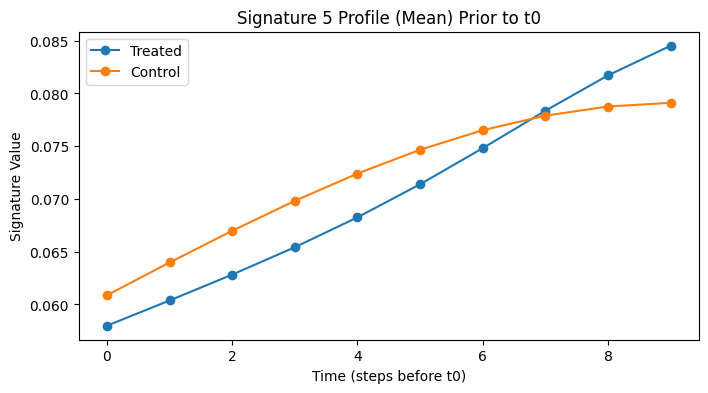

In [17]:

plt.figure(figsize=(8,4))
plt.plot(np.arange(window), treated_sig5_windows.mean(axis=0), label='Treated', marker='o')
plt.plot(np.arange(window), control_sig5_windows.mean(axis=0), label='Control', marker='o')
plt.title('Signature 5 Profile (Mean) Prior to t0')
plt.xlabel('Time (steps before t0)')
plt.ylabel('Signature Value')
plt.legend()

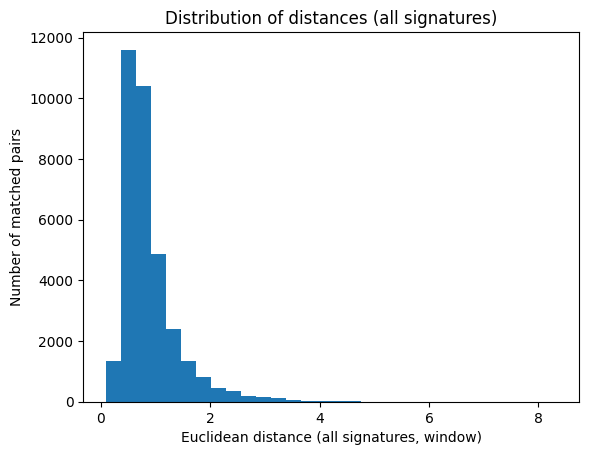

In [18]:
from sklearn.metrics import pairwise_distances

# For each treated, get the distance to its matched control
# If you used NearestNeighbors, you may already have these distances
# Otherwise, compute them:
distances = []
for t_feat, c_idx in zip(treated_features_std, matched_control_indices):
    c_feat = control_features_std[control_indices.index(c_idx)]
    dist = np.linalg.norm(t_feat - c_feat)
    distances.append(dist)

import matplotlib.pyplot as plt
plt.hist(distances, bins=30)
plt.xlabel('Euclidean distance (all signatures, window)')
plt.ylabel('Number of matched pairs')
plt.title('Distribution of distances (all signatures)')
plt.show()

In [33]:
for n in range(5):
    row_in_control_features = indices[n][0]
    original_index = control_indices[row_in_control_features]
    print(f"Treated {n}: matched to row {row_in_control_features} in control_features_std, which is original index {original_index} in processed_ids")
    print("processed_ids[original_index]:", processed_ids[original_index])
    print("matched_control_eids:", matched_control_eids[n])

all([matched_control_eids[n] == processed_ids[control_indices[indices[n][0]]] for n in range(len(matched_control_eids))])

Treated 0: matched to row 207685 in control_features_std, which is original index 227132 in processed_ids
processed_ids[original_index]: 3798308
matched_control_eids: 3798308
Treated 1: matched to row 155883 in control_features_std, which is original index 170522 in processed_ids
processed_ids[original_index]: 3100036
matched_control_eids: 3100036
Treated 2: matched to row 21330 in control_features_std, which is original index 23292 in processed_ids
processed_ids[original_index]: 1287706
matched_control_eids: 1287706
Treated 3: matched to row 127494 in control_features_std, which is original index 139384 in processed_ids
processed_ids[original_index]: 2715230
matched_control_eids: 2715230
Treated 4: matched to row 95010 in control_features_std, which is original index 103817 in processed_ids
processed_ids[original_index]: 2277140
matched_control_eids: 2277140


True

In [29]:
# Find where in control_indices this matched index is
matched_idx = matched_control_indices[100] ## original index of person matched to to the 100th treated person
row_in_control_features = control_indices.index(matched_idx) ## which row in control features corresponds to this original control person
matched_control_feature = control_features[row_in_control_features] # extract the feature vector of this original control person

np.int64(41744)

In [28]:
control_indices[5500]

np.int64(6023)

In [ ]:
sig5_indices

In [ ]:


sig5_indices = np.arange(0, window)
treated_sig5 = treated_sig_windows[:, sig5_indices]
control_sig5 = control_sig_windows[:, sig5_indices]

plt.figure(figsize=(8,4))
plt.plot(np.arange(window), treated_sig5.mean(axis=0), label='Treated', marker='o')
plt.plot(np.arange(window), control_sig5.mean(axis=0), label='Control', marker='o')
plt.title('Signature 15 Profile (Mean) Prior to t0')
plt.xlabel('Time (steps before t0)')
plt.ylabel('Signature Value')
plt.legend()

In [ ]:

# ---------------------------------------------
# 2. Load data: PRS, patient IDs, PRS/disease names, G-matrix, covariates
# ---------------------------------------------
# Load polygenic risk scores (thetas) and processed patient IDs
# These are the main subject IDs and their PRS values
# thetas: (n_individuals, n_prs)
thetas = np.load("thetas.npy")
processed_ids = np.load("processed_patient_ids.npy").astype(int)

# Load PRS names and labels for plotting/interpretation
prs_names = pd.read_csv('prs_names.csv')
prs_labels = prs_names['Names'].tolist()

# Load disease names for reference
# (Assumes second column contains names)
disease_names_df = pd.read_csv("disease_names.csv")
disease_names = disease_names_df.iloc[:, 1].tolist()

# Load G-matrix (genotype/PRS matrix)
G = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/G_matrix.pt")
G = G.detach().cpu().numpy()

# Load covariate data (demographics, labs, etc.)
cov = pd.read_csv('/Users/sarahurbut/aladynoulli2/pyScripts/matched_pce_df_400k.csv')
cov.columns = cov.columns.str.strip()
cov = cov.rename(columns={cov.columns[0]: 'eid'})
cov['eid'] = cov['eid'].astype(int)
# Parse enrollment date and calculate age at enrollment
cov['enrollment'] = pd.to_datetime(cov['Enrollment_Date'], errors='coerce')
cov['age_at_enroll'] = cov['enrollment'].dt.year - cov['birth_year']
age_at_enroll = dict(zip(cov['eid'], cov['age_at_enroll']))
eid_to_yob = dict(zip(cov['eid'], cov['birth_year']))

# ---------------------------------------------
# 3. Load and process prescription data
# ---------------------------------------------
prescription_path = 'prescriptions.csv'
df_treat = pd.read_csv(prescription_path)
df_treat['eid'] = df_treat['eid'].astype(int)
df_treat = df_treat.merge(cov[['eid', 'birth_year']], on='eid', how='left')
df_treat['from'] = pd.to_datetime(df_treat['from'], errors='coerce')

# ---------------------------------------------
# 4. Check overlap between covariate and processed IDs
# ---------------------------------------------
# Convert processed_ids to pandas Series for convenience
processed_ids = pd.Series(processed_ids)

cov_eids = set(cov['eid'])
processed_eids = set(processed_ids)

print("EIDs in cov but not in processed_ids:", cov_eids - processed_eids)
print("EIDs in processed_ids but not in cov:", processed_eids - cov_eids)
print("Number of EIDs in cov:", len(cov_eids))
print("Number of EIDs in processed_ids:", len(processed_eids))
print("Number of overlapping EIDs:", len(cov_eids & processed_eids))

# ---------------------------------------------
# 5. Filter prescription data for drug category (e.g., statins)
# ---------------------------------------------
drug_category = "statins"  # or "antidiabetic", etc.
df_drug = df_treat if drug_category == "All" else df_treat[df_treat['category'] == drug_category]
num_unique_eids = df_drug['eid'].nunique()
print(f"Number of unique individuals in {drug_category}: {num_unique_eids}")
# EIDs in df_treat and cov
treat_eids = set(df_drug['eid'])
overlap_treat_cov = treat_eids & cov_eids
print("Number of people in df_drug:", len(treat_eids))
print("Number of people in both df_drug and cov:", len(overlap_treat_cov))

# ---------------------------------------------
# 6. Identify incident treated individuals (first prescription after enrollment)
# ---------------------------------------------
# Find first prescription for each person
first_presc = df_drug.groupby('eid')['from'].min().reset_index()
first_presc = first_presc.merge(
    cov[['eid', 'Birthdate','Enrollment_Date']],
    left_on='eid', right_on='eid', how='left'
)
first_presc['Birthdate'] = pd.to_datetime(first_presc['Birthdate'])
first_presc['from'] = pd.to_datetime(first_presc['from'])
# Calculate age at first prescription
first_presc['age_at_first_script'] = (first_presc['from'] - first_presc['Birthdate']).dt.days / 365.25
# Only keep those whose first prescription is after enrollment (incident users)
incident_treated = first_presc[first_presc['from'] > first_presc['Enrollment_Date']].copy()
incident_treated['age_at_first_script'] = (incident_treated['from'] - incident_treated['Birthdate']).dt.days/365.25
incident_treated['years_since_30'] = (incident_treated['age_at_first_script'] - 30).round()
incident_treated.shape

# ---------------------------------------------
# 7. Add prior disease/condition flags to covariate table
# ---------------------------------------------
# These functions flag prior disease status at enrollment for each subject
prev_condition(cov, 'Dm_Any', 'Dm_censor_age', 'age_enrolled', 'prev_dm')
prev_condition(cov, 'DmT1_Any', 'DmT1_censor_age', 'age_enrolled', 'prev_dm1')
prev_condition(cov, 'Ht_Any', 'Ht_censor_age', 'age_enrolled', 'prev_ht')
prev_condition(cov, 'HyperLip_Any', 'HyperLip_censor_age', 'age_enrolled', 'prev_hl')

# ---------------------------------------------
# 8. Build mapping dictionaries for covariates and PRS
# ---------------------------------------------
ldl_idx = prs_labels.index('LDL_SF')   # LDL PRS index
cad_idx = prs_labels.index('CAD')      # CAD PRS index
eid_to_dm2_prev = dict(zip(cov['eid'], cov['prev_dm']))
eid_to_antihtnbase = dict(zip(cov['eid'], cov['prev_ht']))
eid_to_htn = dict(zip(cov['eid'], cov['prev_ht']))
eid_to_smoke = dict(zip(cov['eid'], cov['SmokingStatusv2']))
eid_to_dm1_prev = dict(zip(cov['eid'], cov['prev_dm1']))
eid_to_hl_prev = dict(zip(cov['eid'], cov['prev_hl']))
eid_to_sex = dict(zip(cov['eid'],cov['Sex']))
eid_to_age = dict(zip(cov['eid'],cov['age_enrolled']))
eid_to_ldl_prs = {eid: G[i, ldl_idx] for i, eid in enumerate(processed_ids)}
eid_to_cad_prs = {eid: G[i, cad_idx] for i, eid in enumerate(processed_ids)}
eid_to_race = dict(zip(cov['eid'],cov['race']))
eid_to_pce_goff = dict(zip(cov['eid'],cov['pce_goff']))
eid_to_tchol = dict(zip(cov['eid'],cov['tchol']))
eid_to_hdl = dict(zip(cov['eid'],cov['hdl']))
eid_to_sbp = dict(zip(cov['eid'],cov['SBP']))

# ---------------------------------------------
# 9. Define treated and control groups (EIDs and time zero)
# ---------------------------------------------
# Treated: incident users (first prescription after enrollment)
treated_eids = incident_treated['eid']
treated_t0s = incident_treated['years_since_30']
treated_t0_dict = dict(zip(treated_eids, treated_t0s))
len(treated_t0_dict)
len(treated_eids)

# Controls: those not in treated group
# (untreated_eids: EIDs for controls)
treated_eids_set = set(incident_treated['eid'])
untreated_eids = [eid for eid in processed_ids if eid not in treated_eids_set]

# When selecting from covariate DataFrame:
controls_df = cov[cov['eid'].isin(untreated_eids)]
controls = cov[cov['eid'].isin(untreated_eids)].copy()
controls['years_since_30'] = (controls['age_enrolled'] - 30).round()
control_eids = controls['eid']
control_t0s = controls['years_since_30']
print(len(untreated_eids))
print(len(treated_eids_set))
print(len(untreated_eids)+len(treated_eids_set))

# ---------------------------------------------
# 10. Build covariate dictionary for feature engineering
# ---------------------------------------------
covariate_dicts = {
    'age_at_enroll': eid_to_age,
    'sex': eid_to_sex,
    'dm2_prev': eid_to_dm2_prev,
    'antihtnbase': eid_to_antihtnbase,
    'dm1_prev': eid_to_hl_prev,  # Note: check if this is intentional
    'smoke': eid_to_smoke,
    'ldl_prs': eid_to_ldl_prs,
    'cad_prs': eid_to_cad_prs,
    'tchol': eid_to_tchol,
    'hdl': eid_to_hdl,
    'sbp': eid_to_sbp,
    'pce_goff': eid_to_pce_goff
}

# ---------------------------------------------
# 11. Prepare lists of EIDs and t0s for treated and controls
# ---------------------------------------------
from dt import *

treated_eids_list = list(treated_eids)
treated_t0s_list = list(treated_t0s)
control_eids_list = list(control_eids)
control_t0s_list = list(control_t0s)

# ---------------------------------------------
# 12. Build features for matching (using build_features)
# ---------------------------------------------

sig_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

treated_features, treated_indices, treated_eids_matched = build_features(
    treated_eids_list, treated_t0s_list, processed_ids, thetas, covariate_dicts,
    sig_indices=sig_indices
)
control_features, control_indices, control_eids_matched = build_features(
    control_eids_list, control_t0s_list, processed_ids, thetas, covariate_dicts,
    sig_indices=sig_indices
)

# ---------------------------------------------
# 13. Impute missing values and standardize features
# ---------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np
# Impute missing values (mean imputation)
imputer = SimpleImputer(strategy='mean')
all_features = np.vstack([treated_features, control_features])
imputer.fit(all_features)
treated_features_imputed = imputer.transform(treated_features)
control_features_imputed = imputer.transform(control_features)
# Standardize features (zero mean, unit variance)
scaler = StandardScaler().fit(np.vstack([treated_features_imputed, control_features_imputed]))
treated_features_std = scaler.transform(treated_features_imputed)
control_features_std = scaler.transform(control_features_imputed)
print(np.isnan(control_features_std).sum())
print(np.isnan(treated_features_std).sum())

# ---------------------------------------------
# 14. Perform nearest neighbor matching (1:1 matching)
# ---------------------------------------------
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(control_features_std)
distances, indices = nn.kneighbors(treated_features_std)
matched_control_indices = [control_indices[i[0]] for i in indices]
matched_treated_indices = treated_indices  # these are the treateds you matched
matched_control_eids = [control_eids_matched[i] for i in indices.flatten()]

# ---------------------------------------------
# 15. Calculate mean PRS for matched/unmatched cases and controls
# ---------------------------------------------
treated_indices = [np.where(processed_ids == int(eid))[0][0] for eid in treated_eids]
untreated_indices = [np.where(processed_ids == int(eid))[0][0] for eid in untreated_eids]

means_matched_cases = G[matched_treated_indices].mean(axis=0)
means_matched_controls = G[matched_control_indices].mean(axis=0)
means_unmatched_cases = G[treated_indices].mean(axis=0)
means_unmatched_controls = G[untreated_indices].mean(axis=0)

# ---------------------------------------------
# 16. Plot mean PRS for cases/controls (matched and unmatched)
# ---------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(len(prs_labels))
width = 0.35
fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(x - width/2, means_unmatched_cases, width, label='Cases (all)')
ax.bar(x + width/2, means_unmatched_controls, width, label='Controls (all)')
ax.set_ylabel('Mean PGS Value')
ax.set_title('Mean PGS for Cases and Controls (Unmatched)')
ax.set_xticks(x)
ax.set_xticklabels(prs_labels, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(x - width/2, means_matched_cases, width, label='Cases (matched)')
ax.bar(x + width/2, means_matched_controls, width, label='Controls (matched)')
ax.set_ylabel('Mean PGS Value')
ax.set_title('Mean PGS for Cases and Controls (Matched)')
ax.set_xticks(x)
ax.set_xticklabels(prs_labels, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

# ---------------------------------------------
# 17. Compute and plot standardized mean differences (SMD) for PRS
# ---------------------------------------------
def compute_smd(x1, x0):
    m1, m0 = np.nanmean(x1), np.nanmean(x0)
    s1, s0 = np.nanstd(x1), np.nanstd(x0)
    return np.abs(m1 - m0) / np.sqrt((s1**2 + s0**2) / 2)

smds_matched = []
for i, prs in enumerate(prs_labels):
    smds_matched.append(compute_smd(
        G[matched_treated_indices, i], G[matched_control_indices, i]
    ))

x = np.arange(len(prs_labels))
plt.figure(figsize=(16,6))
plt.bar(x, smds_matched, width=0.6)
plt.axhline(0.1, color='red', linestyle='--', label='SMD=0.1')
plt.xticks(x, prs_labels, rotation=90)
plt.ylabel('Standardized Mean Difference')
plt.title('SMD for PGS (Matched)')
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------------------------
# 18. Build group DataFrames for summary tables
# ---------------------------------------------
treated_eids = list(treated_eids)
groups = {
    'Treated (all)': cov[cov['eid'].isin(treated_eids_matched)],
    'Control (all)': cov[cov['eid'].isin(untreated_eids)],
    'Treated (matched)': cov[cov['eid'].isin(treated_eids_matched)],
    'Control (matched)': cov[cov['eid'].isin(matched_control_eids)],
}

print(groups['Treated (all)'].shape)
print(groups['Control (all)'].shape)
print(groups['Treated (matched)'].shape)
print(groups['Control (matched)'].shape)
len(matched_control_eids)

missing = set(matched_control_eids) - set(cov['eid'])
print(f"Number of missing matched control EIDs: {len(missing)}")
print(list(missing)[:10])  # Show a few examples
print(f"Number of unique matched_control_eids: {len(set(matched_control_eids))}")
print(f"Total matched_control_eids: {len(matched_control_eids)}")

# ---------------------------------------------
# 19. Summarize categorical covariates by group
# ---------------------------------------------
categorical_covariates = ['Sex', 'SmokingStatusv2', 'prev_dm', 'prev_hl','race','prev_ht']
for covariate in categorical_covariates:
    # Get all possible categories
    categories = set()
    for df in groups.values():
        categories.update(df[covariate].dropna().unique())
    categories = sorted(categories)
    cat_summary = pd.DataFrame(index=categories)
    for group_name, df in groups.items():
        cat_summary[group_name] = df[covariate].value_counts(normalize=True).reindex(categories, fill_value=0)
    print(f"\n{covariate} distribution table:")
    display(cat_summary.round(3))

# ---------------------------------------------
# 20. Summarize continuous covariates by group
# ---------------------------------------------
covariates = ['age_at_enroll', 'tchol', 'hdl', 'SBP']
summary = pd.DataFrame(index=covariates)
groups = {
    'Treated (all)': cov[cov['eid'].isin(treated_eids_matched)],
    'Control (all)': cov[cov['eid'].isin(untreated_eids)],
    'Treated (matched)': cov[cov['eid'].isin(treated_eids_matched)],
    'Control (matched)': cov[cov['eid'].isin(matched_control_eids)],
}
for group_name, df in groups.items():
    summary[(group_name, 'mean')] = df[covariates].mean()
    summary[(group_name, 'std')] = df[covariates].std()
# Reorder columns for clarity
summary = summary.reindex(columns=pd.MultiIndex.from_product(
    [['Treated (all)', 'Control (all)', 'Treated (matched)', 'Control (matched)'], ['mean', 'std']]
))
# Display as a nice table
summary.round(2)

# ---------------------------------------------
# 21. Compute and plot SMD for phenotypic covariates (matched)
# ---------------------------------------------
treated_matched = cov[cov['eid'].isin(treated_eids_matched)]
control_matched = cov[cov['eid'].isin(matched_control_eids)]
def compute_smd(x1, x0):
    m1, m0 = np.nanmean(x1), np.nanmean(x0)
    s1, s0 = np.nanstd(x1), np.nanstd(x0)
    return np.abs(m1 - m0) / np.sqrt((s1**2 + s0**2) / 2)

covariates = ['age_enrolled', 'tchol', 'hdl', 'SBP', 'pce_goff','Sex','prev_hl','prev_dm','antihtnbase']
smds_matched = []
for covariate in covariates:
    smds_matched.append(compute_smd(
        treated_matched[covariate], control_matched[covariate]
    ))

x = np.arange(len(covariates))
plt.figure(figsize=(8,4))
plt.bar(x, smds_matched, width=0.6)
plt.axhline(0.1, color='red', linestyle='--', label='SMD=0.1')
plt.xticks(x, covariates, rotation=45)
plt.ylabel('Standardized Mean Difference')
plt.title('SMD for Phenotypic Covariates (Matched)')
plt.legend()
plt.tight_layout()
plt.show()

# Print SMDs for reference
for covariate, smd in zip(covariates, smds_matched):
    print(f"{covariate}: SMD = {smd:.3f}")




window = 10  # or whatever window size you use
n_signatures = thetas.shape[1]

# Map from eid to t0
eid_to_t0 = {eid: t0 for eid, t0 in zip(treated_eids_list, treated_t0s_list)}
# Get t0 for each matched treated
matched_treated_t0s = [eid_to_t0[eid] for eid in treated_eids_matched]


treated_sig_windows = []
control_sig_windows = []

for t_idx, c_idx, t0 in zip(matched_treated_indices, matched_control_indices, matched_treated_t0s):
    t0 = int(t0)
    if t0 < window:
        continue  # skip if not enough history
    # Extract signature window for treated
    treated_sig = thetas[t_idx, :, t0-window:t0].flatten()
    # Extract signature window for control (using treated's t0)
    control_sig = thetas[c_idx, :, t0-window:t0].flatten()
    treated_sig_windows.append(treated_sig)
    control_sig_windows.append(control_sig)

treated_sig_windows = np.array(treated_sig_windows)
control_sig_windows = np.array(control_sig_windows)

# Extract the time series for signature 5 and 3

# Indices for signature 5 and 3 in the flattened array
sig5_indices = np.arange(5 * window, 6 * window)
sig3_indices = np.arange(15 * window, 16 * window)

# Extract time series for each signature
treated_sig5 = treated_sig_windows[:, sig5_indices]
control_sig5 = control_sig_windows[:, sig5_indices]
treated_sig3 = treated_sig_windows[:, sig3_indices]
control_sig3 = control_sig_windows[:, sig3_indices]
plt.figure(figsize=(8,4))
plt.plot(np.arange(window), treated_sig5.mean(axis=0), label='Treated', marker='o')
plt.plot(np.arange(window), control_sig5.mean(axis=0), label='Control', marker='o')
plt.title('Signature 5 Profile (Mean) Prior to t0')
plt.xlabel('Time (steps before t0)')
plt.ylabel('Signature Value')
plt.legend()

# compare versus without the signatures

## repeat without sigs

In [8]:
from dt import *

In [ ]:
# ---------------------------------------------
# 1. Import necessary libraries
# ---------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
# %load_ext autoreload  # <-- REMOVE: Jupyter magic, not valid in .py scripts
# %autoreload 2         # <-- REMOVE: Jupyter magic, not valid in .py scripts
from dt import *
import torch
import pandas as pd
# Set seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
# ---------------------------------------------
# 2. Load data: PRS, patient IDs, PRS/disease names, G-matrix, covariates
# ---------------------------------------------
# Load polygenic risk scores (thetas) and processed patient IDs
# These are the main subject IDs and their PRS values
# thetas: (n_individuals, n_prs)
thetas = np.load("thetas.npy")
processed_ids = np.load("processed_patient_ids.npy").astype(int)

# Load PRS names and labels for plotting/interpretation
prs_names = pd.read_csv('prs_names.csv')
prs_labels = prs_names['Names'].tolist()

# Load disease names for reference
# (Assumes second column contains names)
disease_names_df = pd.read_csv("disease_names.csv")
disease_names = disease_names_df.iloc[:, 1].tolist()

# Load G-matrix (genotype/PRS matrix)
G = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/G_matrix.pt")
G = G.detach().cpu().numpy()

# Load covariate data (demographics, labs, etc.)
cov = pd.read_csv('/Users/sarahurbut/aladynoulli2/pyScripts/matched_pce_df_400k.csv')
cov.columns = cov.columns.str.strip()
cov = cov.rename(columns={cov.columns[0]: 'eid'})
cov['eid'] = cov['eid'].astype(int)
# Parse enrollment date and calculate age at enrollment
cov['enrollment'] = pd.to_datetime(cov['Enrollment_Date'], errors='coerce')
cov['age_at_enroll'] = cov['enrollment'].dt.year - cov['birth_year']
age_at_enroll = dict(zip(cov['eid'], cov['age_at_enroll']))
eid_to_yob = dict(zip(cov['eid'], cov['birth_year']))

# ---------------------------------------------
# 3. Load and process prescription data
# ---------------------------------------------
prescription_path = 'prescriptions.csv'
df_treat = pd.read_csv(prescription_path)
df_treat['eid'] = df_treat['eid'].astype(int)
df_treat = df_treat.merge(cov[['eid', 'birth_year']], on='eid', how='left')
df_treat['from'] = pd.to_datetime(df_treat['from'], errors='coerce')

# ---------------------------------------------
# 4. Check overlap between covariate and processed IDs
# ---------------------------------------------
# Convert processed_ids to pandas Series for convenience
processed_ids = pd.Series(processed_ids)

cov_eids = set(cov['eid'])
processed_eids = set(processed_ids)

print("EIDs in cov but not in processed_ids:", cov_eids - processed_eids)
print("EIDs in processed_ids but not in cov:", processed_eids - cov_eids)
print("Number of EIDs in cov:", len(cov_eids))
print("Number of EIDs in processed_ids:", len(processed_eids))
print("Number of overlapping EIDs:", len(cov_eids & processed_eids))

# ---------------------------------------------
# 5. Filter prescription data for drug category (e.g., statins)
# ---------------------------------------------
drug_category = "statins"  # or "antidiabetic", etc.
df_drug = df_treat if drug_category == "All" else df_treat[df_treat['category'] == drug_category]
num_unique_eids = df_drug['eid'].nunique()
print(f"Number of unique individuals in {drug_category}: {num_unique_eids}")
# EIDs in df_treat and cov
treat_eids = set(df_drug['eid'])
overlap_treat_cov = treat_eids & cov_eids
print("Number of people in df_drug:", len(treat_eids))
print("Number of people in both df_drug and cov:", len(overlap_treat_cov))

# ---------------------------------------------
# 6. Identify incident treated individuals (first prescription after enrollment)
# ---------------------------------------------
# Find first prescription for each person
first_presc = df_drug.groupby('eid')['from'].min().reset_index()
first_presc = first_presc.merge(
    cov[['eid', 'Birthdate','Enrollment_Date']],
    left_on='eid', right_on='eid', how='left'
)
first_presc['Birthdate'] = pd.to_datetime(first_presc['Birthdate'])
first_presc['from'] = pd.to_datetime(first_presc['from'])
# Calculate age at first prescription
first_presc['age_at_first_script'] = (first_presc['from'] - first_presc['Birthdate']).dt.days / 365.25
# Only keep those whose first prescription is after enrollment (incident users)
incident_treated = first_presc[first_presc['from'] > first_presc['Enrollment_Date']].copy()
incident_treated['age_at_first_script'] = (incident_treated['from'] - incident_treated['Birthdate']).dt.days/365.25
incident_treated['years_since_30'] = (incident_treated['age_at_first_script'] - 30).round()
incident_treated.shape

# ---------------------------------------------
# 7. Add prior disease/condition flags to covariate table
# ---------------------------------------------
# These functions flag prior disease status at enrollment for each subject
prev_condition(cov, 'Dm_Any', 'Dm_censor_age', 'age_enrolled', 'prev_dm')
prev_condition(cov, 'DmT1_Any', 'DmT1_censor_age', 'age_enrolled', 'prev_dm1')
prev_condition(cov, 'Ht_Any', 'Ht_censor_age', 'age_enrolled', 'prev_ht')
prev_condition(cov, 'HyperLip_Any', 'HyperLip_censor_age', 'age_enrolled', 'prev_hl')

# ---------------------------------------------
# 8. Build mapping dictionaries for covariates and PRS
# ---------------------------------------------
ldl_idx = prs_labels.index('LDL_SF')   # LDL PRS index
cad_idx = prs_labels.index('CAD')      # CAD PRS index
eid_to_dm2_prev = dict(zip(cov['eid'], cov['prev_dm']))
eid_to_antihtnbase = dict(zip(cov['eid'], cov['prev_ht']))
eid_to_htn = dict(zip(cov['eid'], cov['prev_ht']))
eid_to_smoke = dict(zip(cov['eid'], cov['SmokingStatusv2']))
eid_to_dm1_prev = dict(zip(cov['eid'], cov['prev_dm1']))
eid_to_hl_prev = dict(zip(cov['eid'], cov['prev_hl']))
eid_to_sex = dict(zip(cov['eid'],cov['Sex']))
eid_to_age = dict(zip(cov['eid'],cov['age_enrolled']))
eid_to_ldl_prs = {eid: G[i, ldl_idx] for i, eid in enumerate(processed_ids)}
eid_to_cad_prs = {eid: G[i, cad_idx] for i, eid in enumerate(processed_ids)}
eid_to_race = dict(zip(cov['eid'],cov['race']))
eid_to_pce_goff = dict(zip(cov['eid'],cov['pce_goff']))
eid_to_tchol = dict(zip(cov['eid'],cov['tchol']))
eid_to_hdl = dict(zip(cov['eid'],cov['hdl']))
eid_to_sbp = dict(zip(cov['eid'],cov['SBP']))

# ---------------------------------------------
# 9. Define treated and control groups (EIDs and time zero)
# ---------------------------------------------
# Treated: incident users (first prescription after enrollment)
treated_eids = incident_treated['eid']
treated_t0s = incident_treated['years_since_30']
treated_t0_dict = dict(zip(treated_eids, treated_t0s))
len(treated_t0_dict)
len(treated_eids)

# Controls: those not in treated group
# (untreated_eids: EIDs for controls)
treated_eids_set = set(incident_treated['eid'])
untreated_eids = [eid for eid in processed_ids if eid not in treated_eids_set]

# When selecting from covariate DataFrame:
controls_df = cov[cov['eid'].isin(untreated_eids)]
controls = cov[cov['eid'].isin(untreated_eids)].copy()
controls['years_since_30'] = (controls['age_enrolled'] - 30).round()
control_eids = controls['eid']
control_t0s = controls['years_since_30']
print(len(untreated_eids))
print(len(treated_eids_set))
print(len(untreated_eids)+len(treated_eids_set))

# ---------------------------------------------
# 10. Build covariate dictionary for feature engineering
# ---------------------------------------------
covariate_dicts = {
    'age_at_enroll': eid_to_age,
    'sex': eid_to_sex,
    'dm2_prev': eid_to_dm2_prev,
    'antihtnbase': eid_to_antihtnbase,
    'dm1_prev': eid_to_hl_prev,  # Note: check if this is intentional
    'smoke': eid_to_smoke,
    'ldl_prs': eid_to_ldl_prs,
    'cad_prs': eid_to_cad_prs,
    'tchol': eid_to_tchol,
    'hdl': eid_to_hdl,
    'sbp': eid_to_sbp,
    'pce_goff': eid_to_pce_goff
}

# ---------------------------------------------
# 11. Prepare lists of EIDs and t0s for treated and controls
# ---------------------------------------------
from dt import *

treated_eids_list = list(treated_eids)
treated_t0s_list = list(treated_t0s)
control_eids_list = list(control_eids)
control_t0s_list = list(control_t0s)

# ---------------------------------------------
# 12. Build features for matching (using build_features)
# ---------------------------------------------
treated_features, treated_indices, treated_eids_matched = build_features_no_sigs(
    treated_eids_list, treated_t0s_list, processed_ids, covariate_dicts
)
control_features, control_indices, control_eids_matched = build_features_no_sigs(
    control_eids_list, control_t0s_list, processed_ids, covariate_dicts
)


# ---------------------------------------------
# 13. Impute missing values and standardize features
# ---------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np
# Impute missing values (mean imputation)
imputer = SimpleImputer(strategy='mean')
all_features = np.vstack([treated_features, control_features])
imputer.fit(all_features)
treated_features_imputed = imputer.transform(treated_features)
control_features_imputed = imputer.transform(control_features)
# Standardize features (zero mean, unit variance)
scaler = StandardScaler().fit(np.vstack([treated_features_imputed, control_features_imputed]))
treated_features_std = scaler.transform(treated_features_imputed)
control_features_std = scaler.transform(control_features_imputed)
print(np.isnan(control_features_std).sum())
print(np.isnan(treated_features_std).sum())

# ---------------------------------------------
# 14. Perform nearest neighbor matching (1:1 matching)
# ---------------------------------------------
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(control_features_std)
distances, indices = nn.kneighbors(treated_features_std)
matched_control_indices = [control_indices[i[0]] for i in indices]
matched_treated_indices = treated_indices  # these are the treateds you matched
matched_control_eids = [control_eids_matched[i] for i in indices.flatten()]

# ---------------------------------------------
# 15. Calculate mean PRS for matched/unmatched cases and controls
# ---------------------------------------------
treated_indices = [np.where(processed_ids == int(eid))[0][0] for eid in treated_eids]
untreated_indices = [np.where(processed_ids == int(eid))[0][0] for eid in untreated_eids]

means_matched_cases = G[matched_treated_indices].mean(axis=0)
means_matched_controls = G[matched_control_indices].mean(axis=0)
means_unmatched_cases = G[treated_indices].mean(axis=0)
means_unmatched_controls = G[untreated_indices].mean(axis=0)

# ---------------------------------------------
# 16. Plot mean PRS for cases/controls (matched and unmatched)
# ---------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(len(prs_labels))
width = 0.35
fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(x - width/2, means_unmatched_cases, width, label='Cases (all)')
ax.bar(x + width/2, means_unmatched_controls, width, label='Controls (all)')
ax.set_ylabel('Mean PGS Value')
ax.set_title('Mean PGS for Cases and Controls (Unmatched)')
ax.set_xticks(x)
ax.set_xticklabels(prs_labels, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(x - width/2, means_matched_cases, width, label='Cases (matched)')
ax.bar(x + width/2, means_matched_controls, width, label='Controls (matched)')
ax.set_ylabel('Mean PGS Value')
ax.set_title('Mean PGS for Cases and Controls (Matched)')
ax.set_xticks(x)
ax.set_xticklabels(prs_labels, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

# ---------------------------------------------
# 17. Compute and plot standardized mean differences (SMD) for PRS
# ---------------------------------------------
def compute_smd(x1, x0):
    m1, m0 = np.nanmean(x1), np.nanmean(x0)
    s1, s0 = np.nanstd(x1), np.nanstd(x0)
    return np.abs(m1 - m0) / np.sqrt((s1**2 + s0**2) / 2)

smds_matched = []
for i, prs in enumerate(prs_labels):
    smds_matched.append(compute_smd(
        G[matched_treated_indices, i], G[matched_control_indices, i]
    ))

x = np.arange(len(prs_labels))
plt.figure(figsize=(16,6))
plt.bar(x, smds_matched, width=0.6)
plt.axhline(0.1, color='red', linestyle='--', label='SMD=0.1')
plt.xticks(x, prs_labels, rotation=90)
plt.ylabel('Standardized Mean Difference')
plt.title('SMD for PGS (Matched)')
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------------------------
# 18. Build group DataFrames for summary tables
# ---------------------------------------------
treated_eids = list(treated_eids)
groups = {
    'Treated (all)': cov[cov['eid'].isin(treated_eids_matched)],
    'Control (all)': cov[cov['eid'].isin(untreated_eids)],
    'Treated (matched)': cov[cov['eid'].isin(treated_eids_matched)],
    'Control (matched)': cov[cov['eid'].isin(matched_control_eids)],
}

print(groups['Treated (all)'].shape)
print(groups['Control (all)'].shape)
print(groups['Treated (matched)'].shape)
print(groups['Control (matched)'].shape)
len(matched_control_eids)

missing = set(matched_control_eids) - set(cov['eid'])
print(f"Number of missing matched control EIDs: {len(missing)}")
print(list(missing)[:10])  # Show a few examples
print(f"Number of unique matched_control_eids: {len(set(matched_control_eids))}")
print(f"Total matched_control_eids: {len(matched_control_eids)}")

# ---------------------------------------------
# 19. Summarize categorical covariates by group
# ---------------------------------------------
categorical_covariates = ['Sex', 'SmokingStatusv2', 'prev_dm', 'prev_hl','race','prev_ht']
for covariate in categorical_covariates:
    # Get all possible categories
    categories = set()
    for df in groups.values():
        categories.update(df[covariate].dropna().unique())
    categories = sorted(categories)
    cat_summary = pd.DataFrame(index=categories)
    for group_name, df in groups.items():
        cat_summary[group_name] = df[covariate].value_counts(normalize=True).reindex(categories, fill_value=0)
    print(f"\n{covariate} distribution table:")
    display(cat_summary.round(3))

# ---------------------------------------------
# 20. Summarize continuous covariates by group
# ---------------------------------------------
covariates = ['age_at_enroll', 'tchol', 'hdl', 'SBP']
summary = pd.DataFrame(index=covariates)
groups = {
    'Treated (all)': cov[cov['eid'].isin(treated_eids_matched)],
    'Control (all)': cov[cov['eid'].isin(untreated_eids)],
    'Treated (matched)': cov[cov['eid'].isin(treated_eids_matched)],
    'Control (matched)': cov[cov['eid'].isin(matched_control_eids)],
}
for group_name, df in groups.items():
    summary[(group_name, 'mean')] = df[covariates].mean()
    summary[(group_name, 'std')] = df[covariates].std()
# Reorder columns for clarity
summary = summary.reindex(columns=pd.MultiIndex.from_product(
    [['Treated (all)', 'Control (all)', 'Treated (matched)', 'Control (matched)'], ['mean', 'std']]
))
# Display as a nice table
summary.round(2)

# ---------------------------------------------
# 21. Compute and plot SMD for phenotypic covariates (matched)
# ---------------------------------------------
treated_matched = cov[cov['eid'].isin(treated_eids_matched)]
control_matched = cov[cov['eid'].isin(matched_control_eids)]
def compute_smd(x1, x0):
    m1, m0 = np.nanmean(x1), np.nanmean(x0)
    s1, s0 = np.nanstd(x1), np.nanstd(x0)
    return np.abs(m1 - m0) / np.sqrt((s1**2 + s0**2) / 2)

covariates = ['age_enrolled', 'tchol', 'hdl', 'SBP', 'pce_goff','Sex','prev_hl','prev_dm','antihtnbase']
smds_matched = []
for covariate in covariates:
    smds_matched.append(compute_smd(
        treated_matched[covariate], control_matched[covariate]
    ))

x = np.arange(len(covariates))
plt.figure(figsize=(8,4))
plt.bar(x, smds_matched, width=0.6)
plt.axhline(0.1, color='red', linestyle='--', label='SMD=0.1')
plt.xticks(x, covariates, rotation=45)
plt.ylabel('Standardized Mean Difference')
plt.title('SMD for Phenotypic Covariates (Matched)')
plt.legend()
plt.tight_layout()
plt.show()

# Print SMDs for reference
for covariate, smd in zip(covariates, smds_matched):
    print(f"{covariate}: SMD = {smd:.3f}")

In [ ]:
window = 10  # or whatever window size you use
n_signatures = thetas.shape[1]

# Map from eid to t0
eid_to_t0 = {eid: t0 for eid, t0 in zip(treated_eids_list, treated_t0s_list)}
# Get t0 for each matched treated
matched_treated_t0s = [eid_to_t0[eid] for eid in treated_eids_matched]


treated_sig_windows = []
control_sig_windows = []

for t_idx, c_idx, t0 in zip(matched_treated_indices, matched_control_indices, matched_treated_t0s):
    t0 = int(t0)
    if t0 < window:
        continue  # skip if not enough history
    # Extract signature window for treated
    treated_sig = thetas[t_idx, :, t0-window:t0].flatten()
    # Extract signature window for control (using treated's t0)
    control_sig = thetas[c_idx, :, t0-window:t0].flatten()
    treated_sig_windows.append(treated_sig)
    control_sig_windows.append(control_sig)

treated_sig_windows = np.array(treated_sig_windows)
control_sig_windows = np.array(control_sig_windows)

# Extract the time series for signature 5 and 3

# Indices for signature 5 and 3 in the flattened array
sig5_indices = np.arange(5 * window, 6 * window)
sig3_indices = np.arange(3 * window, 4 * window)

# Extract time series for each signature
treated_sig5 = treated_sig_windows[:, sig5_indices]
control_sig5 = control_sig_windows[:, sig5_indices]
treated_sig3 = treated_sig_windows[:, sig3_indices]
control_sig3 = control_sig_windows[:, sig3_indices]
plt.figure(figsize=(8,4))
plt.plot(np.arange(window), treated_sig5.mean(axis=0), label='Treated', marker='o')
plt.plot(np.arange(window), control_sig5.mean(axis=0), label='Control', marker='o')
plt.title('Signature 5 Profile (Mean) Prior to t0')
plt.xlabel('Time (steps before t0)')
plt.ylabel('Signature Value')
plt.legend()
plt.show()

In [14]:
# ---------------------------------------------
# 1. Import necessary libraries
# ---------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
      # <-- REMOVE: Jupyter magic, not valid in .py scripts
from dt import *
import torch
import pandas as pd
# Set seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)

%load_ext autoreload

%autoreload 2
import sys
import os
sys.path.append(os.path.dirname("/Users/sarahurbut/Downloads/"))

from quick_statin_check import *
from statin_identification import *





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
prescription_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/gp_scripts.txt'
gp_scripts = pd.read_csv(prescription_path, sep='\t')

In [20]:
gp_scripts.head()

,eid,data_provider,issue_date,read_2,bnf_code,dmd_code,drug_name,quantity
0,1000015,3,14/06/2005,NaN,06.03.02.00.00,NaN,Prednisolone 5mg gastro-resistant tablets,100
1,1000015,3,28/07/2014,NaN,05.01.01.03.00,NaN,Amoxicillin 500mg capsules,21 capsule
2,1000015,3,10/09/2009,NaN,05.01.01.02.00,NaN,Flucloxacillin 500mg capsules,24 capsules
3,1000015,3,15/12/2004,NaN,03.01.01.03.00,NaN,Salbutamol 100micrograms/dose inhaler,200dose
4,1000015,3,15/12/2004,NaN,03.02.00.00.00,NaN,Beclometasone 200micrograms/dose inhaler,200dose


In [23]:
import pandas as pd
import numpy as np

def simple_gp_check(gp_scripts):
    """
    Very basic check of GP scripts data to avoid type errors
    """
    print("=== Simple GP Scripts Check ===\n")
    
    # Basic shape info
    print(f"Data shape: {gp_scripts.shape}")
    print(f"Columns: {list(gp_scripts.columns)}")
    
    # Check data types
    print(f"\nData types:")
    print(gp_scripts.dtypes)
    
    # Check for missing values
    print(f"\nMissing values:")
    missing = gp_scripts.isnull().sum()
    for col, count in missing.items():
        if count > 0:
            print(f"  {col}: {count}")
    
    # Sample of data
    print(f"\nFirst few rows:")
    print(gp_scripts.head())
    
    # Unique patients
    print(f"\nUnique patients: {gp_scripts['eid'].nunique()}")
    
    return gp_scripts

def find_statins_basic(gp_scripts):
    """
    Basic statin search avoiding type comparison issues
    """
    print("\n=== Basic Statin Search ===\n")
    
    df = gp_scripts.copy()
    
    # Convert to strings safely
    df['drug_name_str'] = df['drug_name'].astype(str)
    df['bnf_code_str'] = df['bnf_code'].astype(str)
    
    # Search for statin keywords in drug names
    statin_keywords = ['statin', 'atorva', 'simva', 'rosuva', 'prava', 'fluva']
    
    statin_mask = False
    for keyword in statin_keywords:
        keyword_mask = df['drug_name_str'].str.contains(keyword, case=False, na=False)
        statin_mask = statin_mask | keyword_mask
        if keyword_mask.sum() > 0:
            print(f"Found {keyword_mask.sum()} prescriptions containing '{keyword}'")
    
    # Search for lipid-related BNF codes
    bnf_patterns = ['2.12', '02.12', '212']
    bnf_mask = False
    for pattern in bnf_patterns:
        pattern_mask = df['bnf_code_str'].str.contains(pattern, na=False)
        bnf_mask = bnf_mask | pattern_mask
        if pattern_mask.sum() > 0:
            print(f"Found {pattern_mask.sum()} prescriptions with BNF pattern '{pattern}'")
    
    # Combine results
    all_statin_mask = statin_mask | bnf_mask
    statins = df[all_statin_mask].copy()
    
    print(f"\nTotal potential statin prescriptions: {len(statins)}")
    
    if len(statins) > 0:
        print(f"Unique patients with statins: {statins['eid'].nunique()}")
        
        # Show sample
        print(f"\nSample statin prescriptions:")
        sample_cols = ['eid', 'issue_date', 'drug_name', 'bnf_code']
        print(statins[sample_cols].head(10))
        
        # Most common statin drugs
        print(f"\nMost common statin drugs:")
        top_drugs = statins['drug_name'].value_counts().head(5)
        for drug, count in top_drugs.items():
            print(f"  {drug}: {count}")
    
    else:
        print("No obvious statins found")
        
        # Show what we do have
        print(f"\nSample of all drug names:")
        print(df['drug_name'].head(10).tolist())
        
        print(f"\nSample of all BNF codes:")
        print(df['bnf_code'].head(10).tolist())
    
    return statins

# Simple function to run
def basic_analysis(gp_scripts):
    """
    Run basic analysis without type errors
    """
    # Basic check
    df = simple_gp_check(gp_scripts)
    
    # Find statins
    statins = find_statins_basic(df)
    
    return df, statins

# Usage:
df, statins = basic_analysis(gp_scripts)

=== Simple GP Scripts Check ===

Data shape: (56212343, 8)
Columns: ['eid', 'data_provider', 'issue_date', 'read_2', 'bnf_code', 'dmd_code', 'drug_name', 'quantity']

Data types:
eid                int64
data_provider      int64
issue_date        object
read_2            object
bnf_code          object
dmd_code         float64
drug_name         object
quantity          object
dtype: object

Missing values:
  issue_date: 6091
  read_2: 42056239
  bnf_code: 13189321
  dmd_code: 50300279
  drug_name: 7228777
  quantity: 7275923

First few rows:
       eid  data_provider  issue_date read_2        bnf_code  dmd_code  \
0  1000015              3  14/06/2005    NaN  06.03.02.00.00       NaN   
1  1000015              3  28/07/2014    NaN  05.01.01.03.00       NaN   
2  1000015              3  10/09/2009    NaN  05.01.01.02.00       NaN   
3  1000015              3  15/12/2004    NaN  03.01.01.03.00       NaN   
4  1000015              3  15/12/2004    NaN  03.02.00.00.00       NaN   

       

True statins after filtering: 3584756
Unique patients with true statins: 70329
Found 53514 treated patients
Found 337814 never-treated patients
=== Learning Treatment Patterns from Observational Data ===

1. Discovering pre-treatment signature clusters...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in m

2. Learning treatment-responsive patterns...
3. Comparing treated vs never-treated patterns...
4. Building treatment readiness predictor...
   Treatment readiness model AUC: 0.665
5. Visualizing learned patterns...


/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in m

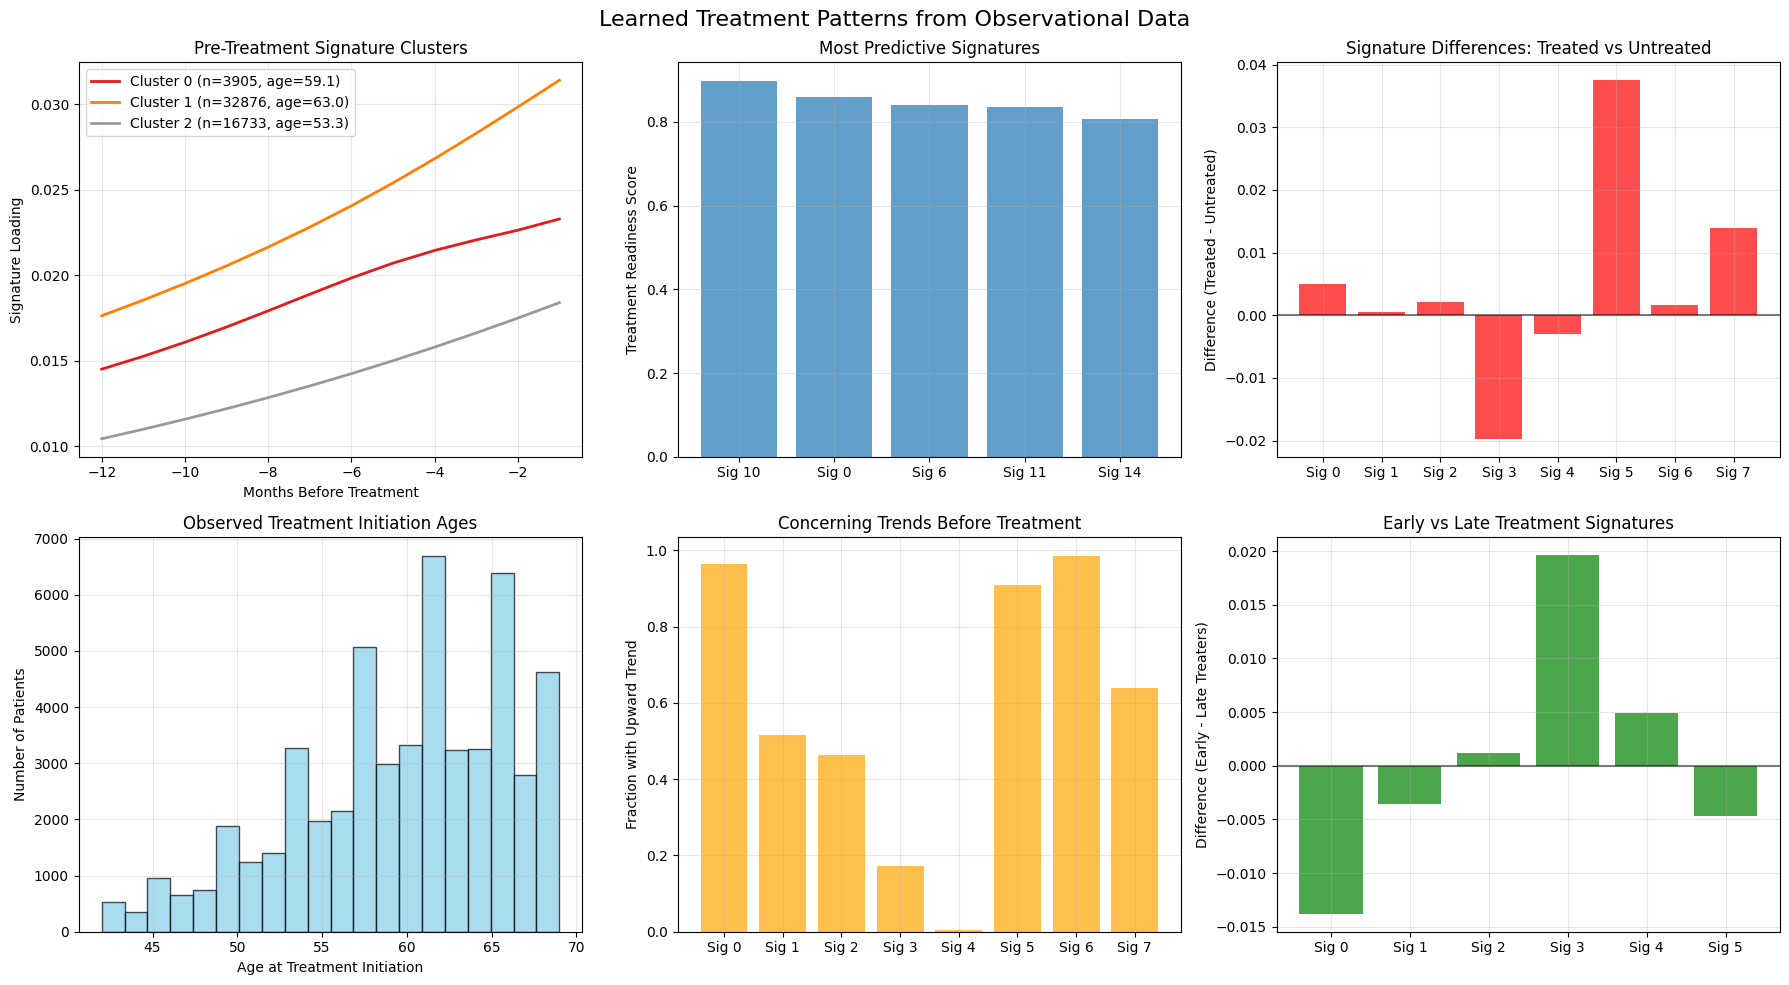

In [33]:
# Clean up the statin data and prepare for signature analysis
# Remove non-statins (like Nystatin which got caught in our search)
from observational_treatment_patterns import *
true_statins = statins[statins['drug_name'].str.contains(
    'simvastatin|atorvastatin|rosuvastatin|pravastatin|fluvastatin|lovastatin', 
    case=False, na=False
)].copy()

print(f"True statins after filtering: {len(true_statins)}")
print(f"Unique patients with true statins: {true_statins['eid'].nunique()}")

# Now let's run the signature analysis!
learner, results = learn_from_observational_data(
    signature_loadings=thetas,  # Your N x K x T signatures
    processed_ids=processed_ids,
    statin_prescriptions=true_statins,
    covariates=cov
)

=== COMPREHENSIVE SIGNATURE ANALYSIS ===

1. Calculating signature differences with effect sizes...

Top signatures by effect size (Cohen's d):
Sig  Treated  Untreated  Raw Diff Cohens d P-value  Significant
4    0.0080   0.0110     -0.0030  -0.6704  0.0000   ***
8    0.0501   0.0875     -0.0374  -0.6312  0.0000   ***
12   0.0077   0.0089     -0.0012  -0.6150  0.0000   ***
5    0.0916   0.0547     0.0369   0.5534   0.0000   ***
3    0.1105   0.1284     -0.0179  -0.3881  0.0000   ***
11   0.0070   0.0063     0.0007   0.3399   0.0000   ***
15   0.0173   0.0152     0.0021   0.3340   0.0000   ***
20   0.0057   0.0060     -0.0003  -0.3036  0.0000   ***
6    0.0110   0.0095     0.0015   0.3029   0.0000   ***
0    0.0268   0.0223     0.0044   0.2828   0.0000   ***

2. Creating signature evolution plots...


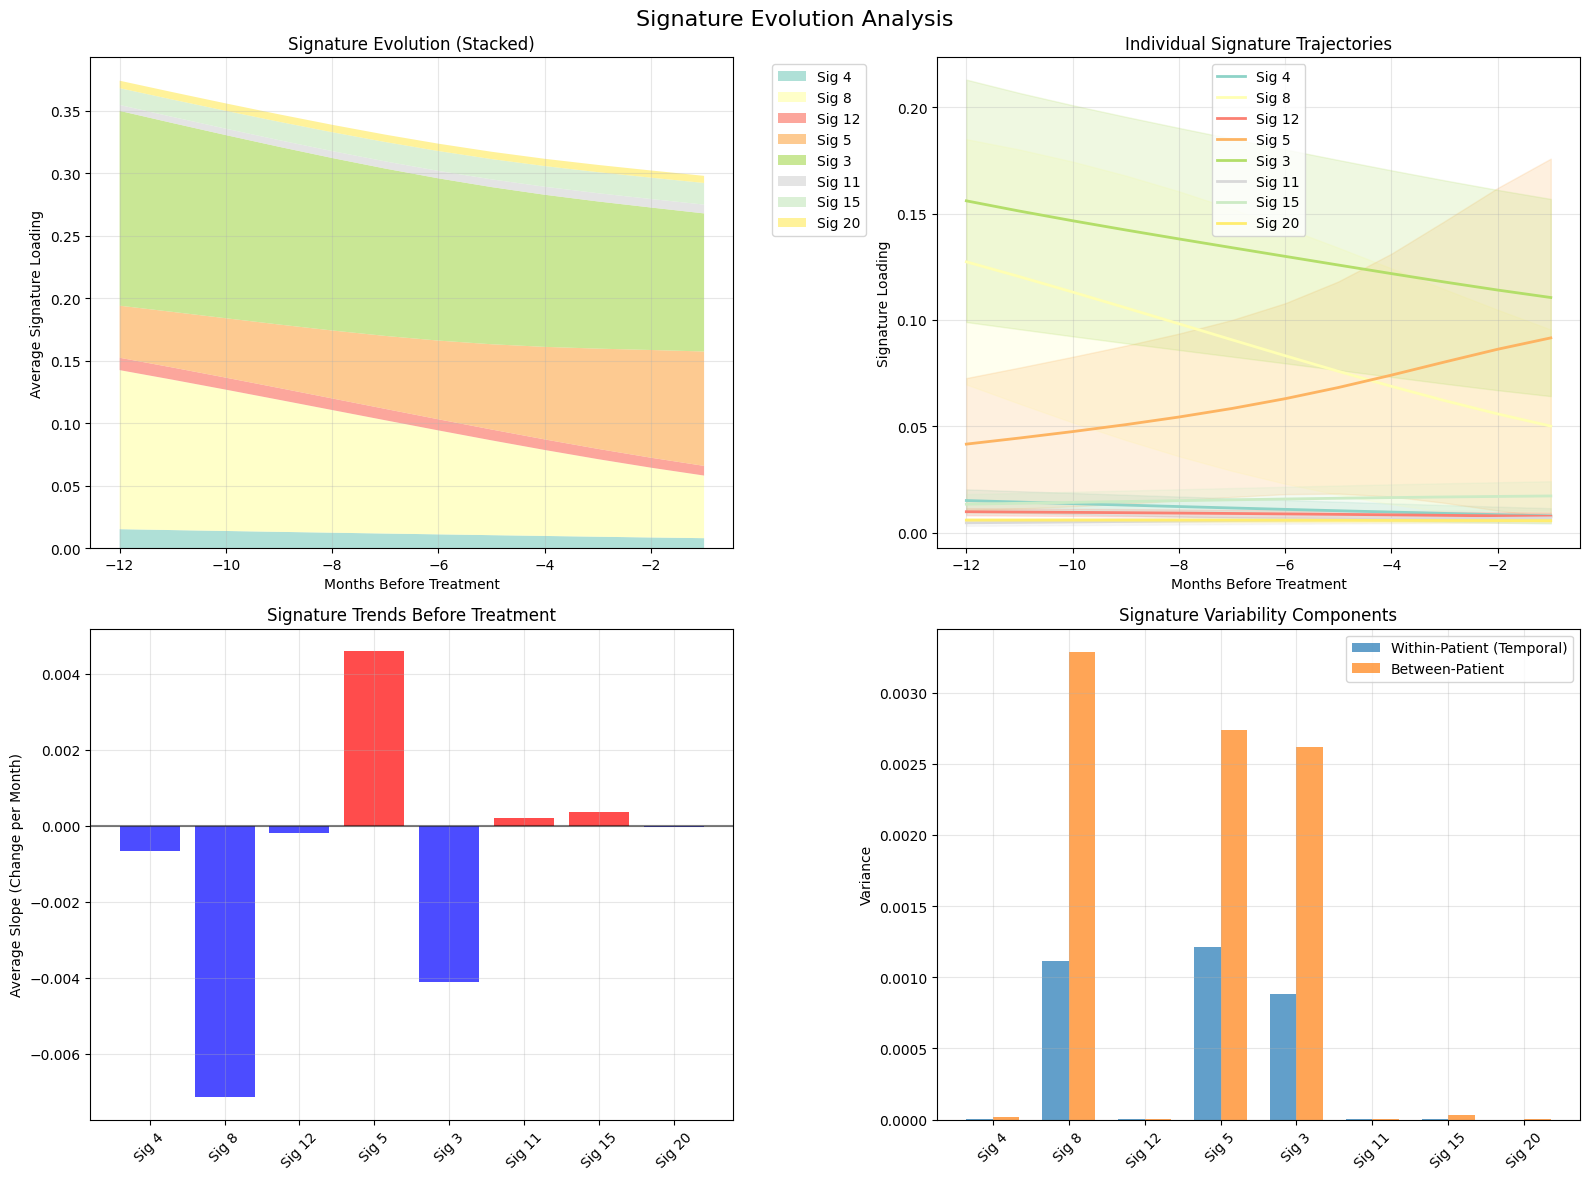


3. Key Insights:
   - 20 signatures show significant differences
   - Signature 4 shows strongest effect (Cohen's d = -0.670)
   - 11 signatures higher in treated patients
   - 9 signatures lower in treated patients


In [46]:
from advanced_signature_analysis import *
# Run the advanced analysis
advanced_results = run_advanced_signature_analysis(learner)

In [30]:
import pandas as pd
import numpy as np

def fix_treatment_timeline_with_correct_age_mapping(statin_prescriptions, processed_ids, 
                                                   covariates, time_grid_start_age=30):
    """
    Create treatment timeline with CORRECT age mapping
    Ages 30-81 map to time indices 0-51 (52 total time points)
    """
    print("=== CREATING TREATMENT TIMELINE WITH CORRECT AGE MAPPING ===\n")
    
    # Convert statin dates
    statin_prescriptions = statin_prescriptions.copy()
    statin_prescriptions['issue_date'] = pd.to_datetime(
        statin_prescriptions['issue_date'], format='%d/%m/%Y', errors='coerce'
    )
    
    # Find first prescription for each patient
    first_prescriptions = (statin_prescriptions
                          .groupby('eid')['issue_date']
                          .min()
                          .reset_index())
    
    treatment_timeline = {
        'treated_eids': [],
        'treatment_times': [],  # Time indices (0-51)
        'treatment_ages': [],   # Actual ages (30-81)
        'never_treated_eids': []
    }
    
    valid_treatments = 0
    out_of_bounds = 0
    missing_data = 0
    
    # Process each patient in the signature data
    for eid in processed_ids:
        try:
            # Check if patient received statins
            patient_prescriptions = first_prescriptions[first_prescriptions['eid'] == eid]
            
            if len(patient_prescriptions) > 0:
                # Patient was treated
                first_date = patient_prescriptions['issue_date'].iloc[0]
                
                # Get birth year
                patient_cov = covariates[covariates['eid'] == eid]
                if len(patient_cov) == 0:
                    missing_data += 1
                    continue
                    
                birth_year = patient_cov['birth_year'].iloc[0]
                age_at_treatment = first_date.year - birth_year
                
                # CORRECT mapping: age 30 = index 0, age 81 = index 51
                # So: time_index = age - 30
                time_idx = age_at_treatment - time_grid_start_age
                
                # Check if within bounds (0 to 51, but need some buffer for analysis)
                if 12 <= time_idx <= 39:  # Need 12 months before, 12 months after
                    treatment_timeline['treated_eids'].append(eid)
                    treatment_timeline['treatment_times'].append(time_idx)
                    treatment_timeline['treatment_ages'].append(age_at_treatment)
                    valid_treatments += 1
                else:
                    out_of_bounds += 1
                    
            else:
                # Patient never treated (in our data)
                treatment_timeline['never_treated_eids'].append(eid)
                
        except Exception as e:
            missing_data += 1
            continue
    
    print(f"Treatment timeline results:")
    print(f"  Valid treated patients: {valid_treatments}")
    print(f"  Out of signature bounds: {out_of_bounds}")
    print(f"  Missing covariate data: {missing_data}")
    print(f"  Never treated: {len(treatment_timeline['never_treated_eids'])}")
    
    if len(treatment_timeline['treatment_ages']) > 0:
        ages = np.array(treatment_timeline['treatment_ages'])
        times = np.array(treatment_timeline['treatment_times'])
        print(f"  Valid treatment ages: {ages.min():.0f} - {ages.max():.0f}")
        print(f"  Corresponding time indices: {times.min():.0f} - {times.max():.0f}")
    
    return treatment_timeline

def test_age_mapping(true_statins, processed_ids, cov):
    """
    Test the corrected age mapping
    """
    print("=== TESTING CORRECTED AGE MAPPING ===\n")
    
    # Test with a few patients
    overlap_patients = list(set(processed_ids) & set(true_statins['eid'].unique()))[:10]
    
    for eid in overlap_patients:
        try:
            # Get first statin
            patient_statins = true_statins[true_statins['eid'] == eid]
            first_date = patient_statins['issue_date'].min()
            first_date = pd.to_datetime(first_date, format='%d/%m/%Y', errors='coerce')
            
            # Get birth year
            patient_cov = cov[cov['eid'] == eid]
            birth_year = patient_cov['birth_year'].iloc[0]
            
            age_at_treatment = first_date.year - birth_year
            
            # OLD (incorrect) calculation
            old_time_idx = (age_at_treatment - 30) * 12
            
            # NEW (correct) calculation  
            new_time_idx = age_at_treatment - 30
            
            print(f"Patient {eid}:")
            print(f"  Age at treatment: {age_at_treatment}")
            print(f"  OLD time index: {old_time_idx} (WRONG - outside 0-51 range)")
            print(f"  NEW time index: {new_time_idx} (CORRECT - within 0-51 range)")
            print(f"  Valid for analysis: {12 <= new_time_idx <= 39}")
            print()
            
        except Exception as e:
            print(f"Patient {eid}: Error - {e}")
    
# Now let's create the corrected treatment timeline
def run_corrected_analysis(true_statins, processed_ids, cov, thetas):
    """
    Run the analysis with corrected age mapping
    """
    # First test the mapping
    test_age_mapping(true_statins, processed_ids, cov)
    
    # Create corrected timeline
    timeline = fix_treatment_timeline_with_correct_age_mapping(
        true_statins, processed_ids, cov
    )
    
    print(f"\nCorrected timeline summary:")
    print(f"Treated patients: {len(timeline['treated_eids'])}")
    print(f"Never treated: {len(timeline['never_treated_eids'])}")
    
    return timeline

# Usage:
corrected_timeline = run_corrected_analysis(true_statins, processed_ids, cov, thetas)

=== TESTING CORRECTED AGE MAPPING ===

Patient 1310720:
  Age at treatment: 66
  OLD time index: 432 (WRONG - outside 0-51 range)
  NEW time index: 36 (CORRECT - within 0-51 range)
  Valid for analysis: True

Patient 1048581:
  Age at treatment: 62
  OLD time index: 384 (WRONG - outside 0-51 range)
  NEW time index: 32 (CORRECT - within 0-51 range)
  Valid for analysis: True

Patient 3407880:
  Age at treatment: 55
  OLD time index: 300 (WRONG - outside 0-51 range)
  NEW time index: 25 (CORRECT - within 0-51 range)
  Valid for analysis: True

Patient 1572874:
  Age at treatment: 64
  OLD time index: 408 (WRONG - outside 0-51 range)
  NEW time index: 34 (CORRECT - within 0-51 range)
  Valid for analysis: True

Patient 1441804:
  Age at treatment: 59
  OLD time index: 348 (WRONG - outside 0-51 range)
  NEW time index: 29 (CORRECT - within 0-51 range)
  Valid for analysis: True

Patient 5242892:
  Age at treatment: 70
  OLD time index: 480 (WRONG - outside 0-51 range)
  NEW time index: 40